In [1]:
import os
import pandas as pd
import numpy as np
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import matplotlib
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
os.listdir('cat_in_dat/')

['train_embeddings_50.csv',
 'train_and_some_test.csv',
 'stacking_catboost_embeddings.csv',
 'catboost_cross_val_le.csv',
 'test_embeddings_50.csv',
 'catboost_cross_val_le_fe_emb_50.csv',
 'train_autoencoder_ohe_20.csv',
 'train_cat_kaggle.csv',
 'test_cat_kaggle.csv',
 'y_test_cat_kaggle.csv',
 'catboost_cross_val_le_fe.csv',
 'stacking_catboost.csv',
 'train_autoencoder_10.csv',
 'test_autoencoder_ohe_20.csv',
 'train.csv',
 'submission_embeddings.csv',
 'test.csv',
 'test_autoencoder_10.csv',
 'catboost_cross_val_le_fe_augmented.csv']

In [3]:
train = pd.read_csv('cat_in_dat/train.csv')
test = pd.read_csv('cat_in_dat/test.csv')
enc_train = pd.read_csv('cat_in_dat/train_autoencoder_ohe_20.csv')
enc_test = pd.read_csv('cat_in_dat/test_autoencoder_ohe_20.csv')
train = pd.concat([train, enc_train], axis=1)
test = pd.concat([test, enc_test], axis=1)

ntrain = train.shape[0]
y_train = train['target'].values.flatten()
train.drop(['target'], axis=1, inplace=True)
test_id = test['id'].values.flatten()

train_test = pd.concat([train, test])
train_test.drop(['id'], axis=1, inplace=True)

del train, test, enc_train, enc_test

In [4]:
train_test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,enc_0,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8,enc_9,enc_10,enc_11,enc_12,enc_13,enc_14,enc_15,enc_16,enc_17,enc_18,enc_19
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,-3.628197,-4.214615,3.162791,-2.851017,0.733684,-2.105170,-3.654043,3.368169,8.733227,-9.304165,-6.155349,-13.961720,-1.860988,3.261696,-2.552499,-7.462784,-6.648254,1.215031,3.039558,-7.457930
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,5.473229,-12.043126,-3.110718,-7.116550,0.137809,0.137545,0.894782,-1.195417,0.025465,-9.848320,-3.185985,-2.082869,1.452042,1.212522,-2.001684,1.752465,-6.622913,-4.465862,1.056876,-2.896130
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,-4.723306,-9.212559,6.908667,-5.521707,-1.525551,-4.305672,-9.828537,-2.415355,7.607178,-13.408950,2.264283,-14.757087,1.142129,2.798655,2.902924,-7.999272,-5.391744,0.190947,-16.148094,-1.135958
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,-0.615331,-11.242261,7.183455,-5.536698,8.040099,-1.410003,-8.376881,-4.480841,1.970797,-9.971006,-12.468792,-6.622226,5.265586,-0.054815,-0.782956,-1.878253,-2.096592,1.068002,2.522064,-1.252572
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,1.041569,1.142792,6.858114,-1.561865,-4.468106,-2.491810,-5.631959,3.342344,2.752319,-14.936157,-5.771559,-10.802589,-0.177584,6.790238,4.165288,-2.998211,-1.888003,3.092746,4.096474,-8.714581


## Feature engineering

In [5]:
train_test['ord_5_1'] = train_test['ord_5'].apply(lambda x: x[0] if type(x) == str else np.nan)
train_test['ord_5_2'] = train_test['ord_5'].apply(lambda x: x[1] if type(x) == str else np.nan)
train_test['ord_5_1_u'] = train_test['ord_5_1'].apply(lambda x: (x.upper() == x)*1 if type(x) == str else np.nan)
train_test['ord_5_2_u'] = train_test['ord_5_2'].apply(lambda x: (x.upper() == x)*1 if type(x) == str else np.nan)

In [6]:
# Converting ordinal labels into ordered values
ord_1 = {
    'Novice' : 0,
    'Contributor' : 1,
    'Expert' : 2,
    'Master' : 3,
    'Grandmaster' : 4
}

ord_2 = {
    'Freezing' : 0,
    'Cold' : 1,
    'Warm' : 2,
    'Hot' : 3,
    'Boiling Hot' : 4,
    'Lava Hot' : 5
}

train_test['ord_1'] = train_test['ord_1'].map(ord_1)
train_test['ord_2'] = train_test['ord_2'].map(ord_2)
train_test['num_nan_count'] = train_test.isnull().sum(axis=1)

In [7]:
bin_col = [col for col in train_test.columns if col.startswith('bin_')]
nom_col = [col for col in train_test.columns if col.startswith('nom_')]
nom_col_low = [c for c in nom_col if len(train_test[c].unique()) <= 10]
nom_col_high = [c for c in nom_col if len(train_test[c].unique()) > 10]
ord_col = [col for col in train_test.columns if col.startswith('ord_')]
num_col = [col for col in train_test.columns if col.startswith('num_') or col.startswith('enc_')]
all_cat_columns = [col for col in train_test.columns if col not in num_col]

In [8]:
%%time
# Label encoder
for col in all_cat_columns:
    fill_value = -1
    if train_test[col].dtype == 'O':
        fill_value = 'missing'
    si = SimpleImputer(strategy='constant', fill_value=fill_value)
    tr = LabelEncoder()
    temp = si.fit_transform(train_test[col].values.reshape(-1, 1))
    train_test[col] = tr.fit_transform(temp.flatten())

CPU times: user 3.4 s, sys: 472 ms, total: 3.88 s
Wall time: 3.88 s


In [9]:
%%time
# Freq encoding
for col in ['nom_1', 'nom_2']:
    fill_value = -1
    if train_test[col].dtype == 'O':
        fill_value = 'missing'
    si = SimpleImputer(strategy='constant', fill_value=fill_value)
    temp = pd.Series(si.fit_transform(train_test[col].values.reshape(-1, 1)).flatten())
    frequencies = temp.value_counts().to_dict()
    train_test[col + '_freq'] = temp.map(frequencies)

CPU times: user 71.2 ms, sys: 152 µs, total: 71.4 ms
Wall time: 70.5 ms


In [10]:
# train_test.drop(all_cat_columns, axis=1, inplace=True)

In [11]:
train_test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,enc_0,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8,enc_9,enc_10,enc_11,enc_12,enc_13,enc_14,enc_15,enc_16,enc_17,enc_18,enc_19,ord_5_1,ord_5_2,ord_5_1_u,ord_5_2_u,num_nan_count,nom_1_freq,nom_2_freq
0,1,1,1,0,0,2,4,3,5,0,1059,1013,87,1,27,3,2,4,2,20,56,6,3,-3.628197,-4.214615,3.162791,-2.851017,0.733684,-2.105170,-3.654043,3.368169,8.733227,-9.304165,-6.155349,-13.961720,-1.860988,3.261696,-2.552499,-7.462784,-6.648254,1.215031,3.039558,-7.457930,15,47,2,1,0,199463,274196
1,2,2,1,0,1,2,3,0,6,3,210,359,27,69,2112,3,5,3,4,23,151,7,7,5.473229,-12.043126,-3.110718,-7.116550,0.137809,0.137545,0.894782,-1.195417,0.025465,-9.848320,-3.185985,-2.082869,1.452042,1.212522,-2.001684,1.752465,-6.622913,-4.465862,1.056876,-2.896130,41,4,1,2,1,23678,254155
2,1,2,1,0,0,2,6,3,0,0,860,694,90,102,2218,3,0,1,14,15,105,5,9,-4.723306,-9.212559,6.908667,-5.521707,-1.525551,-4.305672,-9.828537,-2.415355,7.607178,-13.408950,2.264283,-14.757087,1.142129,2.798655,2.902924,-7.999272,-5.391744,0.190947,-16.148094,-1.135958,29,13,1,2,3,30103,274196
3,0,1,1,0,0,2,0,3,3,3,477,241,51,170,2167,1,1,6,0,2,138,3,3,-0.615331,-11.242261,7.183455,-5.536698,8.040099,-1.410003,-8.376881,-4.480841,1.970797,-9.971006,-12.468792,-6.622226,5.265586,-0.054815,-0.782956,-1.878253,-2.096592,1.068002,2.522064,-1.252572,38,38,0,0,6,175071,274196
4,1,0,1,1,0,2,5,3,2,4,556,361,182,222,1747,3,5,2,7,2,50,5,12,1.041569,1.142792,6.858114,-1.561865,-4.468106,-2.491810,-5.631959,3.342344,2.752319,-14.936157,-5.771559,-10.802589,-0.177584,6.790238,4.165288,-2.998211,-1.888003,3.092746,4.096474,-8.714581,14,25,2,2,3,273832,274196


In [12]:
train_test.shape

(1000000, 50)

In [13]:
train = train_test.iloc[:ntrain]
test = train_test.iloc[ntrain:]

## Grid search

In [14]:
from sklearn.model_selection import ParameterSampler
params = {
    'use_best_model': True,
    'task_type': 'GPU',
    'eval_metric': 'AUC',
    'n_estimators': 10000
}

grid_params = {
    'learning_rate': [.01, .05, .1],
    'depth': [3, 5, 7, 9, 12],
    'l2_leaf_reg': [1, 3, 5],
    'loss_function': ['Logloss', 'CrossEntropy'],
}

list_params = list(ParameterSampler(grid_params,
                                    n_iter=20,
                                    random_state=0))

for param in list_params:
    param.update(params)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y_train, test_size=0.10, random_state=42)

In [16]:
from sklearn.metrics import roc_auc_score
aucs = []
clfs_grid = []
for param in list_params:
    print(param)
    clf = CatBoostClassifier(**param)
    clf.fit(X_train, Y_train,
        eval_set=[(X_valid, Y_valid)],
        cat_features=all_cat_columns,
        early_stopping_rounds=20,
        verbose=5)
    prediction = clf.predict_proba(X_valid)
    auc = roc_auc_score(Y_valid, prediction[: ,1])
    aucs.append(auc)
    clfs_grid.append(clf)

{'loss_function': 'Logloss', 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'depth': 3, 'use_best_model': True, 'task_type': 'GPU', 'eval_metric': 'AUC', 'n_estimators': 10000}
0:	learn: 0.6573722	test: 0.6554305	best: 0.6554305 (0)	total: 37ms	remaining: 6m 10s
5:	learn: 0.6911284	test: 0.6894026	best: 0.6894026 (5)	total: 233ms	remaining: 6m 28s
10:	learn: 0.7013598	test: 0.6990757	best: 0.6990757 (10)	total: 410ms	remaining: 6m 12s
15:	learn: 0.7096830	test: 0.7077917	best: 0.7077917 (15)	total: 583ms	remaining: 6m 3s
20:	learn: 0.7178989	test: 0.7169205	best: 0.7169205 (20)	total: 763ms	remaining: 6m 2s
25:	learn: 0.7240327	test: 0.7233611	best: 0.7233611 (25)	total: 936ms	remaining: 5m 58s
30:	learn: 0.7300868	test: 0.7298205	best: 0.7298205 (30)	total: 1.11s	remaining: 5m 56s
35:	learn: 0.7333300	test: 0.7330808	best: 0.7335860 (33)	total: 1.28s	remaining: 5m 55s
40:	learn: 0.7382007	test: 0.7380086	best: 0.7380086 (40)	total: 1.45s	remaining: 5m 52s
45:	learn: 0.7422954	test: 0.742819

450:	learn: 0.7805518	test: 0.7866440	best: 0.7866498 (449)	total: 15.6s	remaining: 5m 30s
455:	learn: 0.7805809	test: 0.7866603	best: 0.7866607 (454)	total: 15.8s	remaining: 5m 30s
460:	learn: 0.7806103	test: 0.7866952	best: 0.7867083 (459)	total: 16s	remaining: 5m 30s
465:	learn: 0.7806648	test: 0.7867825	best: 0.7867825 (465)	total: 16.1s	remaining: 5m 29s
470:	learn: 0.7807036	test: 0.7868132	best: 0.7868154 (469)	total: 16.3s	remaining: 5m 29s
475:	learn: 0.7807605	test: 0.7868614	best: 0.7868614 (475)	total: 16.5s	remaining: 5m 29s
480:	learn: 0.7808101	test: 0.7869393	best: 0.7869393 (480)	total: 16.6s	remaining: 5m 29s
485:	learn: 0.7808390	test: 0.7869477	best: 0.7869558 (483)	total: 16.8s	remaining: 5m 29s
490:	learn: 0.7808847	test: 0.7869953	best: 0.7869953 (490)	total: 17s	remaining: 5m 29s
495:	learn: 0.7809210	test: 0.7870178	best: 0.7870181 (493)	total: 17.2s	remaining: 5m 28s
500:	learn: 0.7809389	test: 0.7870365	best: 0.7870424 (499)	total: 17.3s	remaining: 5m 28s
505

905:	learn: 0.7824843	test: 0.7884027	best: 0.7884040 (904)	total: 32.4s	remaining: 5m 25s
910:	learn: 0.7824956	test: 0.7884203	best: 0.7884203 (910)	total: 32.6s	remaining: 5m 25s
915:	learn: 0.7825046	test: 0.7884270	best: 0.7884272 (912)	total: 32.8s	remaining: 5m 25s
920:	learn: 0.7825116	test: 0.7884308	best: 0.7884308 (920)	total: 33s	remaining: 5m 24s
925:	learn: 0.7825209	test: 0.7884336	best: 0.7884336 (925)	total: 33.1s	remaining: 5m 24s
930:	learn: 0.7825333	test: 0.7884377	best: 0.7884377 (930)	total: 33.3s	remaining: 5m 24s
935:	learn: 0.7825437	test: 0.7884337	best: 0.7884377 (930)	total: 33.5s	remaining: 5m 23s
940:	learn: 0.7825560	test: 0.7884489	best: 0.7884489 (940)	total: 33.6s	remaining: 5m 23s
945:	learn: 0.7825719	test: 0.7884594	best: 0.7884594 (945)	total: 33.8s	remaining: 5m 23s
950:	learn: 0.7825859	test: 0.7884684	best: 0.7884684 (950)	total: 34s	remaining: 5m 23s
955:	learn: 0.7825931	test: 0.7884750	best: 0.7884750 (955)	total: 34.2s	remaining: 5m 23s
960

345:	learn: 0.7541570	test: 0.7551713	best: 0.7551713 (345)	total: 13.8s	remaining: 6m 24s
350:	learn: 0.7545856	test: 0.7556075	best: 0.7556075 (350)	total: 14s	remaining: 6m 23s
355:	learn: 0.7547849	test: 0.7558629	best: 0.7558629 (355)	total: 14.1s	remaining: 6m 22s
360:	learn: 0.7551474	test: 0.7562789	best: 0.7562789 (360)	total: 14.3s	remaining: 6m 21s
365:	learn: 0.7556102	test: 0.7567944	best: 0.7567944 (365)	total: 14.5s	remaining: 6m 20s
370:	learn: 0.7560521	test: 0.7573053	best: 0.7573053 (370)	total: 14.6s	remaining: 6m 20s
375:	learn: 0.7564730	test: 0.7577546	best: 0.7577546 (375)	total: 14.8s	remaining: 6m 19s
380:	learn: 0.7569104	test: 0.7582535	best: 0.7582535 (380)	total: 15s	remaining: 6m 18s
385:	learn: 0.7572119	test: 0.7585690	best: 0.7585690 (385)	total: 15.2s	remaining: 6m 17s
390:	learn: 0.7575531	test: 0.7589216	best: 0.7589216 (390)	total: 15.3s	remaining: 6m 16s
395:	learn: 0.7577605	test: 0.7591943	best: 0.7591943 (395)	total: 15.5s	remaining: 6m 16s
400

805:	learn: 0.7723088	test: 0.7763105	best: 0.7763105 (805)	total: 31.1s	remaining: 5m 54s
810:	learn: 0.7724346	test: 0.7764551	best: 0.7764551 (810)	total: 31.3s	remaining: 5m 54s
815:	learn: 0.7725261	test: 0.7765714	best: 0.7765714 (815)	total: 31.6s	remaining: 5m 55s
820:	learn: 0.7726656	test: 0.7767348	best: 0.7767348 (820)	total: 31.8s	remaining: 5m 55s
825:	learn: 0.7727554	test: 0.7768232	best: 0.7768232 (825)	total: 32s	remaining: 5m 55s
830:	learn: 0.7728409	test: 0.7769271	best: 0.7769271 (830)	total: 32.2s	remaining: 5m 54s
835:	learn: 0.7729555	test: 0.7770529	best: 0.7770529 (835)	total: 32.3s	remaining: 5m 54s
840:	learn: 0.7729906	test: 0.7770980	best: 0.7770998 (839)	total: 32.5s	remaining: 5m 54s
845:	learn: 0.7730723	test: 0.7771951	best: 0.7771951 (845)	total: 32.8s	remaining: 5m 55s
850:	learn: 0.7731059	test: 0.7772379	best: 0.7772534 (847)	total: 33.1s	remaining: 5m 55s
855:	learn: 0.7731614	test: 0.7773160	best: 0.7773160 (855)	total: 33.3s	remaining: 5m 55s
8

1260:	learn: 0.7772122	test: 0.7824297	best: 0.7824297 (1260)	total: 48.6s	remaining: 5m 36s
1265:	learn: 0.7772334	test: 0.7824554	best: 0.7824554 (1265)	total: 48.8s	remaining: 5m 36s
1270:	learn: 0.7772703	test: 0.7825035	best: 0.7825035 (1270)	total: 48.9s	remaining: 5m 36s
1275:	learn: 0.7773107	test: 0.7825660	best: 0.7825660 (1275)	total: 49.1s	remaining: 5m 35s
1280:	learn: 0.7773472	test: 0.7825939	best: 0.7825949 (1279)	total: 49.3s	remaining: 5m 35s
1285:	learn: 0.7773755	test: 0.7826361	best: 0.7826361 (1285)	total: 49.4s	remaining: 5m 35s
1290:	learn: 0.7774053	test: 0.7826782	best: 0.7826855 (1289)	total: 49.6s	remaining: 5m 34s
1295:	learn: 0.7774498	test: 0.7827294	best: 0.7827294 (1295)	total: 49.8s	remaining: 5m 34s
1300:	learn: 0.7774840	test: 0.7827854	best: 0.7827854 (1300)	total: 50s	remaining: 5m 34s
1305:	learn: 0.7775027	test: 0.7827973	best: 0.7827979 (1303)	total: 50.1s	remaining: 5m 33s
1310:	learn: 0.7775301	test: 0.7828270	best: 0.7828270 (1310)	total: 50.

1710:	learn: 0.7793554	test: 0.7850808	best: 0.7850808 (1710)	total: 1m 4s	remaining: 5m 10s
1715:	learn: 0.7793729	test: 0.7850976	best: 0.7850976 (1715)	total: 1m 4s	remaining: 5m 10s
1720:	learn: 0.7793960	test: 0.7851251	best: 0.7851251 (1720)	total: 1m 4s	remaining: 5m 9s
1725:	learn: 0.7794162	test: 0.7851516	best: 0.7851516 (1725)	total: 1m 4s	remaining: 5m 9s
1730:	learn: 0.7794416	test: 0.7851810	best: 0.7851810 (1730)	total: 1m 4s	remaining: 5m 9s
1735:	learn: 0.7794580	test: 0.7852063	best: 0.7852063 (1735)	total: 1m 4s	remaining: 5m 8s
1740:	learn: 0.7794762	test: 0.7852291	best: 0.7852291 (1740)	total: 1m 5s	remaining: 5m 8s
1745:	learn: 0.7794932	test: 0.7852545	best: 0.7852545 (1745)	total: 1m 5s	remaining: 5m 8s
1750:	learn: 0.7795047	test: 0.7852661	best: 0.7852682 (1748)	total: 1m 5s	remaining: 5m 8s
1755:	learn: 0.7795171	test: 0.7852756	best: 0.7852762 (1754)	total: 1m 5s	remaining: 5m 7s
1760:	learn: 0.7795327	test: 0.7852952	best: 0.7852952 (1760)	total: 1m 5s	rem

2160:	learn: 0.7805240	test: 0.7864718	best: 0.7864718 (2160)	total: 1m 20s	remaining: 4m 52s
2165:	learn: 0.7805319	test: 0.7864740	best: 0.7864743 (2164)	total: 1m 20s	remaining: 4m 52s
2170:	learn: 0.7805390	test: 0.7864796	best: 0.7864796 (2170)	total: 1m 20s	remaining: 4m 51s
2175:	learn: 0.7805505	test: 0.7865003	best: 0.7865003 (2175)	total: 1m 21s	remaining: 4m 51s
2180:	learn: 0.7805591	test: 0.7865111	best: 0.7865111 (2180)	total: 1m 21s	remaining: 4m 51s
2185:	learn: 0.7805688	test: 0.7865236	best: 0.7865236 (2185)	total: 1m 21s	remaining: 4m 51s
2190:	learn: 0.7805795	test: 0.7865333	best: 0.7865333 (2190)	total: 1m 21s	remaining: 4m 51s
2195:	learn: 0.7805902	test: 0.7865444	best: 0.7865444 (2195)	total: 1m 21s	remaining: 4m 50s
2200:	learn: 0.7805985	test: 0.7865515	best: 0.7865515 (2200)	total: 1m 21s	remaining: 4m 50s
2205:	learn: 0.7806094	test: 0.7865617	best: 0.7865617 (2205)	total: 1m 22s	remaining: 4m 50s
2210:	learn: 0.7806183	test: 0.7865816	best: 0.7865816 (2210

2600:	learn: 0.7812235	test: 0.7872638	best: 0.7872638 (2600)	total: 1m 35s	remaining: 4m 32s
2605:	learn: 0.7812307	test: 0.7872646	best: 0.7872654 (2602)	total: 1m 35s	remaining: 4m 32s
2610:	learn: 0.7812403	test: 0.7872766	best: 0.7872766 (2610)	total: 1m 36s	remaining: 4m 31s
2615:	learn: 0.7812488	test: 0.7872874	best: 0.7872874 (2615)	total: 1m 36s	remaining: 4m 31s
2620:	learn: 0.7812580	test: 0.7872966	best: 0.7872966 (2620)	total: 1m 36s	remaining: 4m 31s
2625:	learn: 0.7812621	test: 0.7873028	best: 0.7873028 (2625)	total: 1m 36s	remaining: 4m 31s
2630:	learn: 0.7812675	test: 0.7873065	best: 0.7873065 (2630)	total: 1m 36s	remaining: 4m 30s
2635:	learn: 0.7812744	test: 0.7873172	best: 0.7873172 (2635)	total: 1m 36s	remaining: 4m 30s
2640:	learn: 0.7812808	test: 0.7873268	best: 0.7873268 (2640)	total: 1m 37s	remaining: 4m 30s
2645:	learn: 0.7812865	test: 0.7873331	best: 0.7873331 (2643)	total: 1m 37s	remaining: 4m 30s
2650:	learn: 0.7812921	test: 0.7873389	best: 0.7873389 (2650

3040:	learn: 0.7817004	test: 0.7877111	best: 0.7877111 (3040)	total: 1m 50s	remaining: 4m 13s
3045:	learn: 0.7817049	test: 0.7877151	best: 0.7877151 (3045)	total: 1m 50s	remaining: 4m 13s
3050:	learn: 0.7817096	test: 0.7877197	best: 0.7877197 (3050)	total: 1m 51s	remaining: 4m 13s
3055:	learn: 0.7817130	test: 0.7877228	best: 0.7877230 (3054)	total: 1m 51s	remaining: 4m 12s
3060:	learn: 0.7817189	test: 0.7877296	best: 0.7877296 (3060)	total: 1m 51s	remaining: 4m 12s
3065:	learn: 0.7817231	test: 0.7877334	best: 0.7877334 (3065)	total: 1m 51s	remaining: 4m 12s
3070:	learn: 0.7817296	test: 0.7877395	best: 0.7877395 (3070)	total: 1m 51s	remaining: 4m 12s
3075:	learn: 0.7817339	test: 0.7877477	best: 0.7877477 (3075)	total: 1m 51s	remaining: 4m 12s
3080:	learn: 0.7817373	test: 0.7877468	best: 0.7877484 (3079)	total: 1m 52s	remaining: 4m 11s
3085:	learn: 0.7817407	test: 0.7877474	best: 0.7877492 (3081)	total: 1m 52s	remaining: 4m 11s
3090:	learn: 0.7817445	test: 0.7877535	best: 0.7877535 (3090

3485:	learn: 0.7820635	test: 0.7880171	best: 0.7880175 (3481)	total: 2m 7s	remaining: 3m 58s
3490:	learn: 0.7820670	test: 0.7880190	best: 0.7880191 (3489)	total: 2m 7s	remaining: 3m 57s
3495:	learn: 0.7820699	test: 0.7880206	best: 0.7880206 (3494)	total: 2m 7s	remaining: 3m 57s
3500:	learn: 0.7820733	test: 0.7880238	best: 0.7880238 (3500)	total: 2m 7s	remaining: 3m 57s
3505:	learn: 0.7820778	test: 0.7880281	best: 0.7880281 (3505)	total: 2m 8s	remaining: 3m 57s
3510:	learn: 0.7820807	test: 0.7880306	best: 0.7880306 (3510)	total: 2m 8s	remaining: 3m 57s
3515:	learn: 0.7820837	test: 0.7880348	best: 0.7880348 (3515)	total: 2m 8s	remaining: 3m 56s
3520:	learn: 0.7820880	test: 0.7880385	best: 0.7880385 (3520)	total: 2m 8s	remaining: 3m 56s
3525:	learn: 0.7820927	test: 0.7880417	best: 0.7880432 (3524)	total: 2m 8s	remaining: 3m 56s
3530:	learn: 0.7820945	test: 0.7880431	best: 0.7880437 (3529)	total: 2m 8s	remaining: 3m 56s
3535:	learn: 0.7820969	test: 0.7880436	best: 0.7880437 (3529)	total: 2

3925:	learn: 0.7823372	test: 0.7882352	best: 0.7882352 (3925)	total: 2m 22s	remaining: 3m 40s
3930:	learn: 0.7823406	test: 0.7882372	best: 0.7882372 (3930)	total: 2m 22s	remaining: 3m 40s
3935:	learn: 0.7823426	test: 0.7882381	best: 0.7882389 (3934)	total: 2m 22s	remaining: 3m 39s
3940:	learn: 0.7823444	test: 0.7882383	best: 0.7882389 (3934)	total: 2m 22s	remaining: 3m 39s
3945:	learn: 0.7823490	test: 0.7882447	best: 0.7882448 (3944)	total: 2m 23s	remaining: 3m 39s
3950:	learn: 0.7823517	test: 0.7882478	best: 0.7882478 (3950)	total: 2m 23s	remaining: 3m 39s
3955:	learn: 0.7823555	test: 0.7882492	best: 0.7882503 (3952)	total: 2m 23s	remaining: 3m 39s
3960:	learn: 0.7823573	test: 0.7882496	best: 0.7882503 (3952)	total: 2m 23s	remaining: 3m 38s
3965:	learn: 0.7823603	test: 0.7882507	best: 0.7882518 (3962)	total: 2m 23s	remaining: 3m 38s
3970:	learn: 0.7823641	test: 0.7882536	best: 0.7882536 (3970)	total: 2m 23s	remaining: 3m 38s
3975:	learn: 0.7823668	test: 0.7882552	best: 0.7882562 (3973

4365:	learn: 0.7825513	test: 0.7883655	best: 0.7883675 (4358)	total: 2m 37s	remaining: 3m 22s
4370:	learn: 0.7825531	test: 0.7883684	best: 0.7883684 (4370)	total: 2m 37s	remaining: 3m 22s
4375:	learn: 0.7825556	test: 0.7883707	best: 0.7883707 (4375)	total: 2m 37s	remaining: 3m 22s
4380:	learn: 0.7825582	test: 0.7883708	best: 0.7883708 (4380)	total: 2m 37s	remaining: 3m 22s
4385:	learn: 0.7825602	test: 0.7883733	best: 0.7883733 (4385)	total: 2m 37s	remaining: 3m 22s
4390:	learn: 0.7825624	test: 0.7883737	best: 0.7883737 (4390)	total: 2m 38s	remaining: 3m 21s
4395:	learn: 0.7825649	test: 0.7883772	best: 0.7883772 (4395)	total: 2m 38s	remaining: 3m 21s
4400:	learn: 0.7825679	test: 0.7883777	best: 0.7883777 (4400)	total: 2m 38s	remaining: 3m 21s
4405:	learn: 0.7825705	test: 0.7883789	best: 0.7883789 (4405)	total: 2m 38s	remaining: 3m 21s
4410:	learn: 0.7825724	test: 0.7883810	best: 0.7883810 (4410)	total: 2m 38s	remaining: 3m 21s
4415:	learn: 0.7825740	test: 0.7883820	best: 0.7883820 (4415

4805:	learn: 0.7827421	test: 0.7884939	best: 0.7884951 (4803)	total: 2m 53s	remaining: 3m 7s
4810:	learn: 0.7827438	test: 0.7884941	best: 0.7884951 (4803)	total: 2m 53s	remaining: 3m 7s
4815:	learn: 0.7827460	test: 0.7884951	best: 0.7884951 (4803)	total: 2m 53s	remaining: 3m 7s
4820:	learn: 0.7827485	test: 0.7884971	best: 0.7884971 (4820)	total: 2m 53s	remaining: 3m 6s
4825:	learn: 0.7827501	test: 0.7884974	best: 0.7884974 (4825)	total: 2m 54s	remaining: 3m 6s
4830:	learn: 0.7827519	test: 0.7884970	best: 0.7884974 (4825)	total: 2m 54s	remaining: 3m 6s
4835:	learn: 0.7827532	test: 0.7884977	best: 0.7884983 (4833)	total: 2m 54s	remaining: 3m 6s
4840:	learn: 0.7827550	test: 0.7884986	best: 0.7884986 (4838)	total: 2m 54s	remaining: 3m 6s
4845:	learn: 0.7827573	test: 0.7885016	best: 0.7885020 (4844)	total: 2m 54s	remaining: 3m 6s
4850:	learn: 0.7827600	test: 0.7885024	best: 0.7885031 (4847)	total: 2m 55s	remaining: 3m 5s
4855:	learn: 0.7827618	test: 0.7885023	best: 0.7885031 (4847)	total: 2

40:	learn: 0.7757494	test: 0.7789487	best: 0.7789487 (40)	total: 2.65s	remaining: 10m 44s
45:	learn: 0.7769746	test: 0.7804549	best: 0.7804549 (45)	total: 2.96s	remaining: 10m 40s
50:	learn: 0.7780146	test: 0.7816928	best: 0.7816928 (50)	total: 3.37s	remaining: 10m 56s
55:	learn: 0.7789196	test: 0.7827191	best: 0.7827191 (55)	total: 3.73s	remaining: 11m 1s
60:	learn: 0.7796942	test: 0.7835471	best: 0.7835471 (60)	total: 4.09s	remaining: 11m 7s
65:	learn: 0.7802906	test: 0.7839871	best: 0.7839871 (65)	total: 4.42s	remaining: 11m 4s
70:	learn: 0.7808786	test: 0.7846870	best: 0.7846870 (70)	total: 4.73s	remaining: 11m 1s
75:	learn: 0.7814102	test: 0.7852398	best: 0.7852398 (75)	total: 5.05s	remaining: 10m 59s
80:	learn: 0.7818533	test: 0.7855367	best: 0.7855367 (80)	total: 5.38s	remaining: 10m 59s
85:	learn: 0.7822775	test: 0.7858673	best: 0.7858673 (85)	total: 5.73s	remaining: 11m
90:	learn: 0.7826352	test: 0.7859552	best: 0.7859552 (90)	total: 6.08s	remaining: 11m 2s
95:	learn: 0.783007

125:	learn: 0.7639333	test: 0.7621352	best: 0.7621352 (125)	total: 11.5s	remaining: 15m 2s
130:	learn: 0.7646778	test: 0.7628762	best: 0.7628762 (130)	total: 11.9s	remaining: 15m
135:	learn: 0.7655234	test: 0.7638392	best: 0.7638392 (135)	total: 12.4s	remaining: 14m 58s
140:	learn: 0.7661867	test: 0.7645749	best: 0.7645749 (140)	total: 12.8s	remaining: 14m 57s
145:	learn: 0.7668557	test: 0.7652896	best: 0.7652896 (145)	total: 13.3s	remaining: 14m 56s
150:	learn: 0.7675707	test: 0.7660682	best: 0.7660682 (150)	total: 13.7s	remaining: 14m 56s
155:	learn: 0.7681731	test: 0.7666970	best: 0.7666970 (155)	total: 14.2s	remaining: 14m 55s
160:	learn: 0.7687658	test: 0.7673086	best: 0.7673086 (160)	total: 14.6s	remaining: 14m 52s
165:	learn: 0.7694941	test: 0.7680887	best: 0.7680887 (165)	total: 15s	remaining: 14m 51s
170:	learn: 0.7700708	test: 0.7686782	best: 0.7686782 (170)	total: 15.5s	remaining: 14m 49s
175:	learn: 0.7708133	test: 0.7695183	best: 0.7695183 (175)	total: 15.9s	remaining: 14m

575:	learn: 0.7875427	test: 0.7846755	best: 0.7846755 (575)	total: 53.2s	remaining: 14m 30s
580:	learn: 0.7876397	test: 0.7847328	best: 0.7847328 (580)	total: 53.7s	remaining: 14m 30s
585:	learn: 0.7877350	test: 0.7847784	best: 0.7847784 (585)	total: 54.1s	remaining: 14m 29s
590:	learn: 0.7878205	test: 0.7848196	best: 0.7848196 (590)	total: 54.6s	remaining: 14m 29s
595:	learn: 0.7879340	test: 0.7849025	best: 0.7849025 (595)	total: 55s	remaining: 14m 28s
600:	learn: 0.7880309	test: 0.7849663	best: 0.7849663 (600)	total: 55.5s	remaining: 14m 27s
605:	learn: 0.7881198	test: 0.7849988	best: 0.7849988 (605)	total: 55.9s	remaining: 14m 26s
610:	learn: 0.7881915	test: 0.7850174	best: 0.7850174 (610)	total: 56.4s	remaining: 14m 26s
615:	learn: 0.7882829	test: 0.7850560	best: 0.7850560 (615)	total: 56.8s	remaining: 14m 25s
620:	learn: 0.7883775	test: 0.7850969	best: 0.7850989 (619)	total: 57.3s	remaining: 14m 25s
625:	learn: 0.7884657	test: 0.7851381	best: 0.7851381 (625)	total: 57.7s	remaining

1020:	learn: 0.7939295	test: 0.7873164	best: 0.7873164 (1020)	total: 1m 34s	remaining: 13m 53s
1025:	learn: 0.7939944	test: 0.7873345	best: 0.7873345 (1025)	total: 1m 35s	remaining: 13m 53s
1030:	learn: 0.7940648	test: 0.7873507	best: 0.7873507 (1030)	total: 1m 35s	remaining: 13m 53s
1035:	learn: 0.7941056	test: 0.7873619	best: 0.7873619 (1035)	total: 1m 36s	remaining: 13m 52s
1040:	learn: 0.7941620	test: 0.7873853	best: 0.7873853 (1040)	total: 1m 36s	remaining: 13m 52s
1045:	learn: 0.7942161	test: 0.7874005	best: 0.7874005 (1045)	total: 1m 37s	remaining: 13m 51s
1050:	learn: 0.7942727	test: 0.7874182	best: 0.7874182 (1050)	total: 1m 37s	remaining: 13m 51s
1055:	learn: 0.7943234	test: 0.7874253	best: 0.7874253 (1055)	total: 1m 38s	remaining: 13m 51s
1060:	learn: 0.7943655	test: 0.7874304	best: 0.7874304 (1060)	total: 1m 38s	remaining: 13m 50s
1065:	learn: 0.7944084	test: 0.7874324	best: 0.7874341 (1063)	total: 1m 39s	remaining: 13m 50s
1070:	learn: 0.7944655	test: 0.7874373	best: 0.787

1455:	learn: 0.7981755	test: 0.7881230	best: 0.7881230 (1455)	total: 2m 16s	remaining: 13m 21s
1460:	learn: 0.7982243	test: 0.7881256	best: 0.7881261 (1458)	total: 2m 17s	remaining: 13m 21s
1465:	learn: 0.7982628	test: 0.7881289	best: 0.7881303 (1462)	total: 2m 17s	remaining: 13m 20s
1470:	learn: 0.7983051	test: 0.7881423	best: 0.7881423 (1470)	total: 2m 18s	remaining: 13m 20s
1475:	learn: 0.7983443	test: 0.7881478	best: 0.7881478 (1475)	total: 2m 18s	remaining: 13m 19s
1480:	learn: 0.7983843	test: 0.7881486	best: 0.7881486 (1480)	total: 2m 18s	remaining: 13m 19s
1485:	learn: 0.7984338	test: 0.7881574	best: 0.7881574 (1485)	total: 2m 19s	remaining: 13m 18s
1490:	learn: 0.7984687	test: 0.7881621	best: 0.7881621 (1490)	total: 2m 19s	remaining: 13m 18s
1495:	learn: 0.7985073	test: 0.7881609	best: 0.7881641 (1492)	total: 2m 20s	remaining: 13m 18s
1500:	learn: 0.7985601	test: 0.7881697	best: 0.7881697 (1500)	total: 2m 20s	remaining: 13m 18s
1505:	learn: 0.7985995	test: 0.7881760	best: 0.788

1890:	learn: 0.8016763	test: 0.7884813	best: 0.7884824 (1889)	total: 2m 59s	remaining: 12m 49s
1895:	learn: 0.8017151	test: 0.7884810	best: 0.7884824 (1889)	total: 2m 59s	remaining: 12m 48s
1900:	learn: 0.8017577	test: 0.7884831	best: 0.7884842 (1899)	total: 3m	remaining: 12m 48s
1905:	learn: 0.8017952	test: 0.7884844	best: 0.7884844 (1902)	total: 3m	remaining: 12m 47s
1910:	learn: 0.8018332	test: 0.7884882	best: 0.7884882 (1910)	total: 3m 1s	remaining: 12m 47s
1915:	learn: 0.8018765	test: 0.7884943	best: 0.7884943 (1915)	total: 3m 1s	remaining: 12m 47s
1920:	learn: 0.8019261	test: 0.7885072	best: 0.7885072 (1920)	total: 3m 2s	remaining: 12m 46s
1925:	learn: 0.8019599	test: 0.7885144	best: 0.7885144 (1925)	total: 3m 2s	remaining: 12m 46s
1930:	learn: 0.8020009	test: 0.7885184	best: 0.7885184 (1930)	total: 3m 3s	remaining: 12m 45s
1935:	learn: 0.8020429	test: 0.7885222	best: 0.7885222 (1935)	total: 3m 3s	remaining: 12m 45s
1940:	learn: 0.8020827	test: 0.7885224	best: 0.7885256 (1936)	to

355:	learn: 0.7675903	test: 0.7700858	best: 0.7700858 (355)	total: 18.3s	remaining: 8m 14s
360:	learn: 0.7678518	test: 0.7703851	best: 0.7703851 (360)	total: 18.5s	remaining: 8m 14s
365:	learn: 0.7680826	test: 0.7706369	best: 0.7706369 (365)	total: 18.8s	remaining: 8m 14s
370:	learn: 0.7683484	test: 0.7709692	best: 0.7709692 (370)	total: 19s	remaining: 8m 13s
375:	learn: 0.7686408	test: 0.7713207	best: 0.7713207 (375)	total: 19.3s	remaining: 8m 13s
380:	learn: 0.7688651	test: 0.7715786	best: 0.7715786 (380)	total: 19.5s	remaining: 8m 13s
385:	learn: 0.7691507	test: 0.7719059	best: 0.7719059 (385)	total: 19.8s	remaining: 8m 12s
390:	learn: 0.7693490	test: 0.7721596	best: 0.7721596 (390)	total: 20s	remaining: 8m 12s
395:	learn: 0.7695242	test: 0.7723394	best: 0.7723394 (395)	total: 20.3s	remaining: 8m 12s
400:	learn: 0.7696633	test: 0.7724792	best: 0.7724811 (399)	total: 20.6s	remaining: 8m 12s
405:	learn: 0.7698724	test: 0.7727158	best: 0.7727158 (405)	total: 20.8s	remaining: 8m 11s
410

810:	learn: 0.7782362	test: 0.7828936	best: 0.7828936 (810)	total: 41.5s	remaining: 7m 50s
815:	learn: 0.7782896	test: 0.7829497	best: 0.7829497 (815)	total: 41.7s	remaining: 7m 49s
820:	learn: 0.7783442	test: 0.7830115	best: 0.7830115 (820)	total: 42s	remaining: 7m 49s
825:	learn: 0.7783781	test: 0.7830467	best: 0.7830467 (825)	total: 42.3s	remaining: 7m 49s
830:	learn: 0.7784297	test: 0.7831076	best: 0.7831076 (830)	total: 42.5s	remaining: 7m 49s
835:	learn: 0.7784891	test: 0.7831676	best: 0.7831676 (835)	total: 42.8s	remaining: 7m 49s
840:	learn: 0.7785391	test: 0.7832388	best: 0.7832388 (840)	total: 43.1s	remaining: 7m 48s
845:	learn: 0.7785718	test: 0.7832949	best: 0.7832949 (845)	total: 43.3s	remaining: 7m 48s
850:	learn: 0.7786134	test: 0.7833389	best: 0.7833389 (850)	total: 43.6s	remaining: 7m 48s
855:	learn: 0.7786562	test: 0.7833900	best: 0.7833900 (855)	total: 43.8s	remaining: 7m 48s
860:	learn: 0.7787116	test: 0.7834571	best: 0.7834571 (860)	total: 44.1s	remaining: 7m 48s
8

1260:	learn: 0.7810530	test: 0.7860878	best: 0.7860878 (1260)	total: 1m 4s	remaining: 7m 30s
1265:	learn: 0.7810741	test: 0.7861223	best: 0.7861223 (1265)	total: 1m 5s	remaining: 7m 29s
1270:	learn: 0.7810990	test: 0.7861541	best: 0.7861541 (1270)	total: 1m 5s	remaining: 7m 29s
1275:	learn: 0.7811206	test: 0.7861761	best: 0.7861784 (1274)	total: 1m 5s	remaining: 7m 29s
1280:	learn: 0.7811374	test: 0.7861918	best: 0.7861926 (1279)	total: 1m 5s	remaining: 7m 29s
1285:	learn: 0.7811584	test: 0.7862090	best: 0.7862090 (1285)	total: 1m 6s	remaining: 7m 28s
1290:	learn: 0.7811786	test: 0.7862338	best: 0.7862338 (1290)	total: 1m 6s	remaining: 7m 28s
1295:	learn: 0.7811958	test: 0.7862452	best: 0.7862452 (1295)	total: 1m 6s	remaining: 7m 28s
1300:	learn: 0.7812095	test: 0.7862588	best: 0.7862588 (1300)	total: 1m 7s	remaining: 7m 28s
1305:	learn: 0.7812286	test: 0.7862797	best: 0.7862797 (1305)	total: 1m 7s	remaining: 7m 28s
1310:	learn: 0.7812396	test: 0.7862809	best: 0.7862829 (1307)	total: 1

1700:	learn: 0.7823668	test: 0.7873558	best: 0.7873558 (1700)	total: 1m 27s	remaining: 7m 7s
1705:	learn: 0.7823769	test: 0.7873662	best: 0.7873684 (1704)	total: 1m 27s	remaining: 7m 7s
1710:	learn: 0.7823865	test: 0.7873741	best: 0.7873741 (1710)	total: 1m 28s	remaining: 7m 7s
1715:	learn: 0.7824007	test: 0.7873857	best: 0.7873857 (1715)	total: 1m 28s	remaining: 7m 7s
1720:	learn: 0.7824101	test: 0.7873956	best: 0.7873956 (1720)	total: 1m 28s	remaining: 7m 6s
1725:	learn: 0.7824221	test: 0.7874054	best: 0.7874054 (1725)	total: 1m 28s	remaining: 7m 6s
1730:	learn: 0.7824345	test: 0.7874171	best: 0.7874171 (1730)	total: 1m 29s	remaining: 7m 6s
1735:	learn: 0.7824420	test: 0.7874199	best: 0.7874207 (1732)	total: 1m 29s	remaining: 7m 6s
1740:	learn: 0.7824513	test: 0.7874339	best: 0.7874339 (1740)	total: 1m 29s	remaining: 7m 5s
1745:	learn: 0.7824653	test: 0.7874440	best: 0.7874440 (1745)	total: 1m 30s	remaining: 7m 5s
1750:	learn: 0.7824736	test: 0.7874535	best: 0.7874535 (1750)	total: 1

2140:	learn: 0.7831917	test: 0.7879245	best: 0.7879248 (2139)	total: 1m 50s	remaining: 6m 46s
2145:	learn: 0.7831995	test: 0.7879271	best: 0.7879274 (2144)	total: 1m 50s	remaining: 6m 45s
2150:	learn: 0.7832068	test: 0.7879339	best: 0.7879339 (2150)	total: 1m 51s	remaining: 6m 45s
2155:	learn: 0.7832131	test: 0.7879412	best: 0.7879412 (2155)	total: 1m 51s	remaining: 6m 45s
2160:	learn: 0.7832209	test: 0.7879447	best: 0.7879447 (2160)	total: 1m 51s	remaining: 6m 45s
2165:	learn: 0.7832306	test: 0.7879481	best: 0.7879483 (2164)	total: 1m 52s	remaining: 6m 45s
2170:	learn: 0.7832396	test: 0.7879561	best: 0.7879561 (2170)	total: 1m 52s	remaining: 6m 44s
2175:	learn: 0.7832476	test: 0.7879634	best: 0.7879634 (2175)	total: 1m 52s	remaining: 6m 44s
2180:	learn: 0.7832557	test: 0.7879725	best: 0.7879725 (2180)	total: 1m 52s	remaining: 6m 44s
2185:	learn: 0.7832641	test: 0.7879776	best: 0.7879776 (2185)	total: 1m 53s	remaining: 6m 44s
2190:	learn: 0.7832724	test: 0.7879823	best: 0.7879823 (2190

2580:	learn: 0.7837850	test: 0.7882482	best: 0.7882507 (2574)	total: 2m 13s	remaining: 6m 25s
2585:	learn: 0.7837905	test: 0.7882511	best: 0.7882511 (2585)	total: 2m 14s	remaining: 6m 24s
2590:	learn: 0.7837964	test: 0.7882548	best: 0.7882550 (2589)	total: 2m 14s	remaining: 6m 24s
2595:	learn: 0.7838018	test: 0.7882588	best: 0.7882588 (2595)	total: 2m 14s	remaining: 6m 24s
2600:	learn: 0.7838089	test: 0.7882630	best: 0.7882630 (2600)	total: 2m 14s	remaining: 6m 23s
2605:	learn: 0.7838148	test: 0.7882658	best: 0.7882662 (2603)	total: 2m 15s	remaining: 6m 23s
2610:	learn: 0.7838216	test: 0.7882673	best: 0.7882673 (2610)	total: 2m 15s	remaining: 6m 23s
2615:	learn: 0.7838282	test: 0.7882698	best: 0.7882701 (2614)	total: 2m 15s	remaining: 6m 23s
2620:	learn: 0.7838348	test: 0.7882737	best: 0.7882737 (2620)	total: 2m 16s	remaining: 6m 23s
2625:	learn: 0.7838398	test: 0.7882752	best: 0.7882760 (2623)	total: 2m 16s	remaining: 6m 22s
2630:	learn: 0.7838455	test: 0.7882753	best: 0.7882760 (2623

3020:	learn: 0.7842950	test: 0.7884530	best: 0.7884538 (3018)	total: 2m 37s	remaining: 6m 3s
3025:	learn: 0.7843003	test: 0.7884552	best: 0.7884554 (3023)	total: 2m 37s	remaining: 6m 3s
3030:	learn: 0.7843065	test: 0.7884580	best: 0.7884580 (3030)	total: 2m 38s	remaining: 6m 3s
3035:	learn: 0.7843116	test: 0.7884572	best: 0.7884587 (3031)	total: 2m 38s	remaining: 6m 3s
3040:	learn: 0.7843168	test: 0.7884569	best: 0.7884587 (3031)	total: 2m 38s	remaining: 6m 2s
3045:	learn: 0.7843220	test: 0.7884607	best: 0.7884607 (3045)	total: 2m 38s	remaining: 6m 2s
3050:	learn: 0.7843282	test: 0.7884626	best: 0.7884626 (3050)	total: 2m 39s	remaining: 6m 2s
3055:	learn: 0.7843326	test: 0.7884595	best: 0.7884626 (3050)	total: 2m 39s	remaining: 6m 2s
3060:	learn: 0.7843381	test: 0.7884628	best: 0.7884628 (3060)	total: 2m 39s	remaining: 6m 1s
3065:	learn: 0.7843436	test: 0.7884642	best: 0.7884642 (3065)	total: 2m 39s	remaining: 6m 1s
3070:	learn: 0.7843509	test: 0.7884645	best: 0.7884645 (3070)	total: 2

290:	learn: 0.7859113	test: 0.7872036	best: 0.7872036 (290)	total: 18.5s	remaining: 10m 16s
295:	learn: 0.7860077	test: 0.7872364	best: 0.7872364 (295)	total: 18.8s	remaining: 10m 16s
300:	learn: 0.7861119	test: 0.7872787	best: 0.7872787 (300)	total: 19.2s	remaining: 10m 17s
305:	learn: 0.7862101	test: 0.7873192	best: 0.7873246 (303)	total: 19.5s	remaining: 10m 17s
310:	learn: 0.7863020	test: 0.7873520	best: 0.7873520 (310)	total: 19.8s	remaining: 10m 17s
315:	learn: 0.7863913	test: 0.7873790	best: 0.7873790 (315)	total: 20.1s	remaining: 10m 17s
320:	learn: 0.7864686	test: 0.7874006	best: 0.7874006 (320)	total: 20.5s	remaining: 10m 17s
325:	learn: 0.7865509	test: 0.7874385	best: 0.7874385 (325)	total: 20.8s	remaining: 10m 17s
330:	learn: 0.7866271	test: 0.7874503	best: 0.7874546 (329)	total: 21.1s	remaining: 10m 17s
335:	learn: 0.7867219	test: 0.7874958	best: 0.7874958 (335)	total: 21.5s	remaining: 10m 17s
340:	learn: 0.7868115	test: 0.7875460	best: 0.7875460 (340)	total: 21.8s	remaini

250:	learn: 0.7690354	test: 0.7704621	best: 0.7704621 (250)	total: 15.6s	remaining: 10m 6s
255:	learn: 0.7695117	test: 0.7710036	best: 0.7710036 (255)	total: 15.9s	remaining: 10m 6s
260:	learn: 0.7697082	test: 0.7712362	best: 0.7712362 (260)	total: 16.2s	remaining: 10m 5s
265:	learn: 0.7700203	test: 0.7715655	best: 0.7715655 (265)	total: 16.6s	remaining: 10m 6s
270:	learn: 0.7704351	test: 0.7720315	best: 0.7720315 (270)	total: 16.9s	remaining: 10m 5s
275:	learn: 0.7707668	test: 0.7724051	best: 0.7724051 (275)	total: 17.2s	remaining: 10m 4s
280:	learn: 0.7710979	test: 0.7727963	best: 0.7727963 (280)	total: 17.5s	remaining: 10m 4s
285:	learn: 0.7712905	test: 0.7729473	best: 0.7729473 (285)	total: 17.8s	remaining: 10m 3s
290:	learn: 0.7716684	test: 0.7733924	best: 0.7733924 (290)	total: 18.1s	remaining: 10m 3s
295:	learn: 0.7719696	test: 0.7737842	best: 0.7737842 (295)	total: 18.4s	remaining: 10m 2s
300:	learn: 0.7721670	test: 0.7740479	best: 0.7740479 (300)	total: 18.7s	remaining: 10m 2s

705:	learn: 0.7814834	test: 0.7845063	best: 0.7845063 (705)	total: 44s	remaining: 9m 39s
710:	learn: 0.7815406	test: 0.7845701	best: 0.7845701 (710)	total: 44.4s	remaining: 9m 39s
715:	learn: 0.7815959	test: 0.7846376	best: 0.7846376 (715)	total: 44.7s	remaining: 9m 39s
720:	learn: 0.7816569	test: 0.7847010	best: 0.7847010 (720)	total: 45s	remaining: 9m 38s
725:	learn: 0.7817105	test: 0.7847412	best: 0.7847412 (725)	total: 45.3s	remaining: 9m 38s
730:	learn: 0.7817649	test: 0.7847984	best: 0.7847984 (730)	total: 45.6s	remaining: 9m 38s
735:	learn: 0.7818102	test: 0.7848181	best: 0.7848181 (735)	total: 45.9s	remaining: 9m 38s
740:	learn: 0.7818564	test: 0.7848463	best: 0.7848463 (740)	total: 46.2s	remaining: 9m 37s
745:	learn: 0.7819062	test: 0.7848862	best: 0.7848862 (745)	total: 46.6s	remaining: 9m 37s
750:	learn: 0.7819576	test: 0.7849330	best: 0.7849330 (750)	total: 46.9s	remaining: 9m 37s
755:	learn: 0.7820007	test: 0.7849679	best: 0.7849679 (755)	total: 47.2s	remaining: 9m 37s
760

1155:	learn: 0.7847998	test: 0.7870765	best: 0.7870765 (1155)	total: 1m 13s	remaining: 9m 21s
1160:	learn: 0.7848255	test: 0.7870964	best: 0.7870964 (1160)	total: 1m 13s	remaining: 9m 21s
1165:	learn: 0.7848505	test: 0.7871063	best: 0.7871072 (1164)	total: 1m 14s	remaining: 9m 20s
1170:	learn: 0.7848761	test: 0.7871254	best: 0.7871254 (1170)	total: 1m 14s	remaining: 9m 20s
1175:	learn: 0.7849034	test: 0.7871466	best: 0.7871466 (1175)	total: 1m 14s	remaining: 9m 20s
1180:	learn: 0.7849311	test: 0.7871649	best: 0.7871649 (1180)	total: 1m 15s	remaining: 9m 20s
1185:	learn: 0.7849552	test: 0.7871807	best: 0.7871807 (1185)	total: 1m 15s	remaining: 9m 19s
1190:	learn: 0.7849870	test: 0.7872061	best: 0.7872061 (1190)	total: 1m 15s	remaining: 9m 19s
1195:	learn: 0.7850136	test: 0.7872244	best: 0.7872244 (1195)	total: 1m 16s	remaining: 9m 19s
1200:	learn: 0.7850357	test: 0.7872382	best: 0.7872382 (1200)	total: 1m 16s	remaining: 9m 19s
1205:	learn: 0.7850593	test: 0.7872511	best: 0.7872511 (1205

1595:	learn: 0.7867149	test: 0.7879876	best: 0.7879876 (1595)	total: 1m 42s	remaining: 8m 59s
1600:	learn: 0.7867330	test: 0.7879940	best: 0.7879940 (1600)	total: 1m 42s	remaining: 8m 58s
1605:	learn: 0.7867490	test: 0.7879920	best: 0.7879952 (1603)	total: 1m 43s	remaining: 8m 58s
1610:	learn: 0.7867656	test: 0.7879991	best: 0.7879991 (1610)	total: 1m 43s	remaining: 8m 58s
1615:	learn: 0.7867846	test: 0.7880039	best: 0.7880039 (1615)	total: 1m 43s	remaining: 8m 58s
1620:	learn: 0.7867990	test: 0.7880039	best: 0.7880039 (1615)	total: 1m 44s	remaining: 8m 57s
1625:	learn: 0.7868167	test: 0.7880093	best: 0.7880093 (1625)	total: 1m 44s	remaining: 8m 57s
1630:	learn: 0.7868330	test: 0.7880147	best: 0.7880147 (1630)	total: 1m 44s	remaining: 8m 57s
1635:	learn: 0.7868510	test: 0.7880197	best: 0.7880213 (1634)	total: 1m 45s	remaining: 8m 57s
1640:	learn: 0.7868667	test: 0.7880284	best: 0.7880284 (1640)	total: 1m 45s	remaining: 8m 56s
1645:	learn: 0.7868837	test: 0.7880392	best: 0.7880392 (1645

2035:	learn: 0.7881595	test: 0.7884120	best: 0.7884120 (2035)	total: 2m 12s	remaining: 8m 36s
2040:	learn: 0.7881742	test: 0.7884144	best: 0.7884144 (2040)	total: 2m 12s	remaining: 8m 36s
2045:	learn: 0.7881880	test: 0.7884188	best: 0.7884188 (2045)	total: 2m 12s	remaining: 8m 36s
2050:	learn: 0.7882022	test: 0.7884215	best: 0.7884215 (2050)	total: 2m 13s	remaining: 8m 35s
2055:	learn: 0.7882176	test: 0.7884244	best: 0.7884244 (2055)	total: 2m 13s	remaining: 8m 35s
2060:	learn: 0.7882342	test: 0.7884316	best: 0.7884316 (2060)	total: 2m 13s	remaining: 8m 35s
2065:	learn: 0.7882478	test: 0.7884343	best: 0.7884344 (2064)	total: 2m 14s	remaining: 8m 35s
2070:	learn: 0.7882671	test: 0.7884361	best: 0.7884367 (2068)	total: 2m 14s	remaining: 8m 34s
2075:	learn: 0.7882773	test: 0.7884369	best: 0.7884380 (2073)	total: 2m 14s	remaining: 8m 34s
2080:	learn: 0.7882916	test: 0.7884369	best: 0.7884385 (2079)	total: 2m 15s	remaining: 8m 34s
2085:	learn: 0.7883082	test: 0.7884423	best: 0.7884423 (2085

10:	learn: 0.7567399	test: 0.7441065	best: 0.7441065 (10)	total: 3.19s	remaining: 48m 13s
15:	learn: 0.7566223	test: 0.7446947	best: 0.7446947 (15)	total: 4.59s	remaining: 47m 47s
20:	learn: 0.7589825	test: 0.7464213	best: 0.7464366 (19)	total: 6s	remaining: 47m 32s
25:	learn: 0.7610332	test: 0.7480440	best: 0.7483632 (23)	total: 7.47s	remaining: 47m 46s
30:	learn: 0.7626843	test: 0.7492949	best: 0.7492949 (30)	total: 8.89s	remaining: 47m 40s
35:	learn: 0.7642787	test: 0.7506909	best: 0.7506909 (35)	total: 10.3s	remaining: 47m 35s
40:	learn: 0.7659908	test: 0.7521497	best: 0.7521497 (40)	total: 11.8s	remaining: 47m 46s
45:	learn: 0.7669331	test: 0.7531610	best: 0.7531610 (45)	total: 13.2s	remaining: 47m 39s
50:	learn: 0.7690217	test: 0.7550173	best: 0.7550173 (50)	total: 14.6s	remaining: 47m 33s
55:	learn: 0.7704452	test: 0.7562304	best: 0.7562304 (55)	total: 16.1s	remaining: 47m 35s
60:	learn: 0.7717128	test: 0.7572717	best: 0.7572717 (60)	total: 17.5s	remaining: 47m 37s
65:	learn: 0.

460:	learn: 0.8230680	test: 0.7845877	best: 0.7845877 (460)	total: 2m 13s	remaining: 46m 4s
465:	learn: 0.8234677	test: 0.7846448	best: 0.7846448 (465)	total: 2m 15s	remaining: 46m 3s
470:	learn: 0.8238068	test: 0.7847100	best: 0.7847100 (470)	total: 2m 16s	remaining: 46m 2s
475:	learn: 0.8242036	test: 0.7847770	best: 0.7847770 (475)	total: 2m 18s	remaining: 46m 2s
480:	learn: 0.8245248	test: 0.7848425	best: 0.7848425 (480)	total: 2m 19s	remaining: 46m
485:	learn: 0.8248676	test: 0.7849258	best: 0.7849258 (485)	total: 2m 20s	remaining: 45m 59s
490:	learn: 0.8252165	test: 0.7849595	best: 0.7849595 (490)	total: 2m 22s	remaining: 45m 59s
495:	learn: 0.8255433	test: 0.7849929	best: 0.7849929 (495)	total: 2m 23s	remaining: 45m 58s
500:	learn: 0.8258902	test: 0.7850443	best: 0.7850443 (500)	total: 2m 25s	remaining: 45m 56s
505:	learn: 0.8262455	test: 0.7850964	best: 0.7850964 (505)	total: 2m 26s	remaining: 45m 55s
510:	learn: 0.8265622	test: 0.7851732	best: 0.7851732 (510)	total: 2m 28s	rema

905:	learn: 0.8483425	test: 0.7872887	best: 0.7872887 (905)	total: 4m 25s	remaining: 44m 27s
910:	learn: 0.8485717	test: 0.7872995	best: 0.7872995 (910)	total: 4m 27s	remaining: 44m 26s
915:	learn: 0.8487735	test: 0.7872971	best: 0.7873036 (913)	total: 4m 28s	remaining: 44m 25s
920:	learn: 0.8490447	test: 0.7873242	best: 0.7873242 (920)	total: 4m 30s	remaining: 44m 23s
925:	learn: 0.8492531	test: 0.7873438	best: 0.7873438 (925)	total: 4m 31s	remaining: 44m 22s
930:	learn: 0.8494846	test: 0.7873584	best: 0.7873584 (930)	total: 4m 33s	remaining: 44m 21s
935:	learn: 0.8497140	test: 0.7873636	best: 0.7873636 (935)	total: 4m 34s	remaining: 44m 20s
940:	learn: 0.8499346	test: 0.7873850	best: 0.7873885 (939)	total: 4m 36s	remaining: 44m 18s
945:	learn: 0.8501632	test: 0.7873858	best: 0.7873885 (939)	total: 4m 37s	remaining: 44m 17s
950:	learn: 0.8503728	test: 0.7873991	best: 0.7873991 (950)	total: 4m 39s	remaining: 44m 16s
955:	learn: 0.8506227	test: 0.7874045	best: 0.7874045 (955)	total: 4m 

1340:	learn: 0.8670598	test: 0.7880917	best: 0.7880921 (1337)	total: 6m 35s	remaining: 42m 34s
1345:	learn: 0.8672632	test: 0.7880931	best: 0.7880967 (1341)	total: 6m 37s	remaining: 42m 32s
1350:	learn: 0.8674697	test: 0.7880845	best: 0.7880967 (1341)	total: 6m 38s	remaining: 42m 31s
1355:	learn: 0.8676636	test: 0.7880885	best: 0.7880967 (1341)	total: 6m 40s	remaining: 42m 30s
1360:	learn: 0.8679112	test: 0.7881099	best: 0.7881099 (1360)	total: 6m 41s	remaining: 42m 28s
1365:	learn: 0.8681446	test: 0.7881129	best: 0.7881167 (1362)	total: 6m 43s	remaining: 42m 27s
1370:	learn: 0.8683084	test: 0.7881264	best: 0.7881264 (1370)	total: 6m 44s	remaining: 42m 26s
1375:	learn: 0.8685263	test: 0.7881414	best: 0.7881414 (1375)	total: 6m 46s	remaining: 42m 24s
1380:	learn: 0.8687001	test: 0.7881364	best: 0.7881446 (1378)	total: 6m 47s	remaining: 42m 23s
1385:	learn: 0.8688836	test: 0.7881440	best: 0.7881446 (1378)	total: 6m 49s	remaining: 42m 22s
1390:	learn: 0.8690898	test: 0.7881390	best: 0.788

240:	learn: 0.7438564	test: 0.7437015	best: 0.7437015 (240)	total: 8.33s	remaining: 5m 37s
245:	learn: 0.7443756	test: 0.7443276	best: 0.7443838 (244)	total: 8.5s	remaining: 5m 37s
250:	learn: 0.7449784	test: 0.7450309	best: 0.7450642 (249)	total: 8.68s	remaining: 5m 37s
255:	learn: 0.7454785	test: 0.7455782	best: 0.7455782 (255)	total: 8.85s	remaining: 5m 37s
260:	learn: 0.7460890	test: 0.7461876	best: 0.7461876 (260)	total: 9.02s	remaining: 5m 36s
265:	learn: 0.7467023	test: 0.7468981	best: 0.7468981 (265)	total: 9.2s	remaining: 5m 36s
270:	learn: 0.7474416	test: 0.7476044	best: 0.7476044 (270)	total: 9.38s	remaining: 5m 36s
275:	learn: 0.7478642	test: 0.7481048	best: 0.7481048 (275)	total: 9.55s	remaining: 5m 36s
280:	learn: 0.7484364	test: 0.7487622	best: 0.7487622 (280)	total: 9.72s	remaining: 5m 36s
285:	learn: 0.7490101	test: 0.7493560	best: 0.7493560 (285)	total: 9.89s	remaining: 5m 35s
290:	learn: 0.7491446	test: 0.7495168	best: 0.7496083 (289)	total: 10.1s	remaining: 5m 35s
2

700:	learn: 0.7702585	test: 0.7737595	best: 0.7737595 (700)	total: 24.3s	remaining: 5m 21s
705:	learn: 0.7703198	test: 0.7738348	best: 0.7738348 (705)	total: 24.4s	remaining: 5m 21s
710:	learn: 0.7703480	test: 0.7738450	best: 0.7738450 (710)	total: 24.6s	remaining: 5m 21s
715:	learn: 0.7704386	test: 0.7739689	best: 0.7739689 (715)	total: 24.8s	remaining: 5m 21s
720:	learn: 0.7705804	test: 0.7741281	best: 0.7741289 (719)	total: 24.9s	remaining: 5m 21s
725:	learn: 0.7707345	test: 0.7743184	best: 0.7743184 (725)	total: 25.1s	remaining: 5m 20s
730:	learn: 0.7708685	test: 0.7744918	best: 0.7744918 (730)	total: 25.3s	remaining: 5m 20s
735:	learn: 0.7709938	test: 0.7746618	best: 0.7746618 (735)	total: 25.5s	remaining: 5m 20s
740:	learn: 0.7710779	test: 0.7747718	best: 0.7747718 (740)	total: 25.6s	remaining: 5m 20s
745:	learn: 0.7711962	test: 0.7749693	best: 0.7749693 (745)	total: 25.8s	remaining: 5m 19s
750:	learn: 0.7712646	test: 0.7750667	best: 0.7750667 (750)	total: 26s	remaining: 5m 19s
7

1150:	learn: 0.7764335	test: 0.7814471	best: 0.7814509 (1149)	total: 39.7s	remaining: 5m 5s
1155:	learn: 0.7764731	test: 0.7814814	best: 0.7814814 (1155)	total: 39.9s	remaining: 5m 4s
1160:	learn: 0.7764913	test: 0.7814832	best: 0.7814902 (1158)	total: 40s	remaining: 5m 4s
1165:	learn: 0.7765209	test: 0.7815254	best: 0.7815254 (1165)	total: 40.2s	remaining: 5m 4s
1170:	learn: 0.7765579	test: 0.7815798	best: 0.7815798 (1170)	total: 40.4s	remaining: 5m 4s
1175:	learn: 0.7766020	test: 0.7816314	best: 0.7816314 (1175)	total: 40.5s	remaining: 5m 4s
1180:	learn: 0.7766441	test: 0.7816676	best: 0.7816676 (1180)	total: 40.7s	remaining: 5m 3s
1185:	learn: 0.7766836	test: 0.7817407	best: 0.7817407 (1185)	total: 40.9s	remaining: 5m 3s
1190:	learn: 0.7767208	test: 0.7817896	best: 0.7817896 (1190)	total: 41.1s	remaining: 5m 3s
1195:	learn: 0.7767674	test: 0.7818498	best: 0.7818498 (1195)	total: 41.2s	remaining: 5m 3s
1200:	learn: 0.7768002	test: 0.7818962	best: 0.7818962 (1200)	total: 41.4s	remaini

1600:	learn: 0.7789600	test: 0.7845985	best: 0.7845985 (1600)	total: 55.2s	remaining: 4m 49s
1605:	learn: 0.7789795	test: 0.7846148	best: 0.7846194 (1604)	total: 55.3s	remaining: 4m 49s
1610:	learn: 0.7790021	test: 0.7846443	best: 0.7846443 (1610)	total: 55.5s	remaining: 4m 49s
1615:	learn: 0.7790128	test: 0.7846519	best: 0.7846525 (1614)	total: 55.7s	remaining: 4m 48s
1620:	learn: 0.7790327	test: 0.7846701	best: 0.7846701 (1620)	total: 55.9s	remaining: 4m 48s
1625:	learn: 0.7790514	test: 0.7846917	best: 0.7846917 (1625)	total: 56s	remaining: 4m 48s
1630:	learn: 0.7790699	test: 0.7847175	best: 0.7847208 (1629)	total: 56.2s	remaining: 4m 48s
1635:	learn: 0.7790849	test: 0.7847353	best: 0.7847407 (1634)	total: 56.4s	remaining: 4m 48s
1640:	learn: 0.7791057	test: 0.7847631	best: 0.7847631 (1640)	total: 56.5s	remaining: 4m 48s
1645:	learn: 0.7791278	test: 0.7847984	best: 0.7847984 (1645)	total: 56.7s	remaining: 4m 47s
1650:	learn: 0.7791439	test: 0.7848158	best: 0.7848158 (1650)	total: 56.

2050:	learn: 0.7803000	test: 0.7861848	best: 0.7861848 (2050)	total: 1m 10s	remaining: 4m 33s
2055:	learn: 0.7803108	test: 0.7861963	best: 0.7861963 (2055)	total: 1m 10s	remaining: 4m 33s
2060:	learn: 0.7803236	test: 0.7862095	best: 0.7862095 (2060)	total: 1m 10s	remaining: 4m 33s
2065:	learn: 0.7803419	test: 0.7862270	best: 0.7862270 (2065)	total: 1m 11s	remaining: 4m 33s
2070:	learn: 0.7803544	test: 0.7862417	best: 0.7862417 (2070)	total: 1m 11s	remaining: 4m 33s
2075:	learn: 0.7803633	test: 0.7862481	best: 0.7862485 (2074)	total: 1m 11s	remaining: 4m 32s
2080:	learn: 0.7803738	test: 0.7862619	best: 0.7862619 (2080)	total: 1m 11s	remaining: 4m 32s
2085:	learn: 0.7803823	test: 0.7862675	best: 0.7862700 (2084)	total: 1m 11s	remaining: 4m 32s
2090:	learn: 0.7803943	test: 0.7862865	best: 0.7862865 (2090)	total: 1m 12s	remaining: 4m 32s
2095:	learn: 0.7804076	test: 0.7863000	best: 0.7863000 (2095)	total: 1m 12s	remaining: 4m 32s
2100:	learn: 0.7804181	test: 0.7863090	best: 0.7863090 (2100

2490:	learn: 0.7810838	test: 0.7870915	best: 0.7870915 (2490)	total: 1m 25s	remaining: 4m 18s
2495:	learn: 0.7810902	test: 0.7870977	best: 0.7870977 (2495)	total: 1m 25s	remaining: 4m 18s
2500:	learn: 0.7810995	test: 0.7871046	best: 0.7871046 (2500)	total: 1m 26s	remaining: 4m 18s
2505:	learn: 0.7811089	test: 0.7871138	best: 0.7871138 (2505)	total: 1m 26s	remaining: 4m 18s
2510:	learn: 0.7811149	test: 0.7871158	best: 0.7871158 (2510)	total: 1m 26s	remaining: 4m 17s
2515:	learn: 0.7811208	test: 0.7871267	best: 0.7871267 (2515)	total: 1m 26s	remaining: 4m 17s
2520:	learn: 0.7811263	test: 0.7871290	best: 0.7871290 (2520)	total: 1m 26s	remaining: 4m 17s
2525:	learn: 0.7811325	test: 0.7871360	best: 0.7871360 (2525)	total: 1m 27s	remaining: 4m 17s
2530:	learn: 0.7811365	test: 0.7871370	best: 0.7871370 (2530)	total: 1m 27s	remaining: 4m 17s
2535:	learn: 0.7811436	test: 0.7871424	best: 0.7871439 (2534)	total: 1m 27s	remaining: 4m 17s
2540:	learn: 0.7811484	test: 0.7871481	best: 0.7871517 (2537

2930:	learn: 0.7815982	test: 0.7876202	best: 0.7876211 (2926)	total: 1m 40s	remaining: 4m 3s
2935:	learn: 0.7816032	test: 0.7876267	best: 0.7876267 (2935)	total: 1m 41s	remaining: 4m 3s
2940:	learn: 0.7816094	test: 0.7876274	best: 0.7876274 (2940)	total: 1m 41s	remaining: 4m 2s
2945:	learn: 0.7816146	test: 0.7876322	best: 0.7876322 (2945)	total: 1m 41s	remaining: 4m 2s
2950:	learn: 0.7816198	test: 0.7876394	best: 0.7876394 (2950)	total: 1m 41s	remaining: 4m 2s
2955:	learn: 0.7816255	test: 0.7876402	best: 0.7876414 (2954)	total: 1m 41s	remaining: 4m 2s
2960:	learn: 0.7816309	test: 0.7876460	best: 0.7876460 (2960)	total: 1m 41s	remaining: 4m 2s
2965:	learn: 0.7816348	test: 0.7876458	best: 0.7876464 (2962)	total: 1m 42s	remaining: 4m 2s
2970:	learn: 0.7816386	test: 0.7876525	best: 0.7876525 (2970)	total: 1m 42s	remaining: 4m 1s
2975:	learn: 0.7816437	test: 0.7876579	best: 0.7876579 (2975)	total: 1m 42s	remaining: 4m 1s
2980:	learn: 0.7816503	test: 0.7876622	best: 0.7876622 (2980)	total: 1

3375:	learn: 0.7819882	test: 0.7879609	best: 0.7879609 (3375)	total: 1m 56s	remaining: 3m 47s
3380:	learn: 0.7819926	test: 0.7879663	best: 0.7879663 (3380)	total: 1m 56s	remaining: 3m 47s
3385:	learn: 0.7819977	test: 0.7879672	best: 0.7879672 (3385)	total: 1m 56s	remaining: 3m 47s
3390:	learn: 0.7820008	test: 0.7879652	best: 0.7879674 (3386)	total: 1m 56s	remaining: 3m 47s
3395:	learn: 0.7820041	test: 0.7879694	best: 0.7879694 (3395)	total: 1m 56s	remaining: 3m 46s
3400:	learn: 0.7820067	test: 0.7879701	best: 0.7879701 (3400)	total: 1m 56s	remaining: 3m 46s
3405:	learn: 0.7820107	test: 0.7879727	best: 0.7879752 (3403)	total: 1m 57s	remaining: 3m 46s
3410:	learn: 0.7820166	test: 0.7879778	best: 0.7879778 (3410)	total: 1m 57s	remaining: 3m 46s
3415:	learn: 0.7820194	test: 0.7879794	best: 0.7879794 (3415)	total: 1m 57s	remaining: 3m 46s
3420:	learn: 0.7820225	test: 0.7879839	best: 0.7879839 (3420)	total: 1m 57s	remaining: 3m 46s
3425:	learn: 0.7820268	test: 0.7879880	best: 0.7879880 (3425

3815:	learn: 0.7822738	test: 0.7881542	best: 0.7881546 (3810)	total: 2m 10s	remaining: 3m 32s
3820:	learn: 0.7822792	test: 0.7881611	best: 0.7881611 (3820)	total: 2m 11s	remaining: 3m 32s
3825:	learn: 0.7822830	test: 0.7881635	best: 0.7881635 (3825)	total: 2m 11s	remaining: 3m 31s
3830:	learn: 0.7822866	test: 0.7881680	best: 0.7881680 (3830)	total: 2m 11s	remaining: 3m 31s
3835:	learn: 0.7822903	test: 0.7881727	best: 0.7881727 (3835)	total: 2m 11s	remaining: 3m 31s
3840:	learn: 0.7822924	test: 0.7881719	best: 0.7881731 (3837)	total: 2m 11s	remaining: 3m 31s
3845:	learn: 0.7822953	test: 0.7881784	best: 0.7881784 (3845)	total: 2m 12s	remaining: 3m 31s
3850:	learn: 0.7822973	test: 0.7881800	best: 0.7881800 (3850)	total: 2m 12s	remaining: 3m 31s
3855:	learn: 0.7823002	test: 0.7881824	best: 0.7881824 (3855)	total: 2m 12s	remaining: 3m 30s
3860:	learn: 0.7823054	test: 0.7881858	best: 0.7881862 (3859)	total: 2m 12s	remaining: 3m 30s
3865:	learn: 0.7823091	test: 0.7881896	best: 0.7881896 (3865

4255:	learn: 0.7825137	test: 0.7883318	best: 0.7883331 (4249)	total: 2m 25s	remaining: 3m 16s
4260:	learn: 0.7825153	test: 0.7883324	best: 0.7883331 (4249)	total: 2m 26s	remaining: 3m 16s
4265:	learn: 0.7825179	test: 0.7883331	best: 0.7883341 (4262)	total: 2m 26s	remaining: 3m 16s
4270:	learn: 0.7825193	test: 0.7883344	best: 0.7883344 (4270)	total: 2m 26s	remaining: 3m 16s
4275:	learn: 0.7825222	test: 0.7883356	best: 0.7883356 (4275)	total: 2m 26s	remaining: 3m 16s
4280:	learn: 0.7825240	test: 0.7883350	best: 0.7883363 (4277)	total: 2m 26s	remaining: 3m 16s
4285:	learn: 0.7825261	test: 0.7883353	best: 0.7883363 (4277)	total: 2m 26s	remaining: 3m 15s
4290:	learn: 0.7825289	test: 0.7883402	best: 0.7883402 (4290)	total: 2m 27s	remaining: 3m 15s
4295:	learn: 0.7825310	test: 0.7883419	best: 0.7883424 (4292)	total: 2m 27s	remaining: 3m 15s
4300:	learn: 0.7825331	test: 0.7883414	best: 0.7883424 (4292)	total: 2m 27s	remaining: 3m 15s
4305:	learn: 0.7825348	test: 0.7883411	best: 0.7883424 (4292

4695:	learn: 0.7827087	test: 0.7884548	best: 0.7884548 (4695)	total: 2m 40s	remaining: 3m 1s
4700:	learn: 0.7827104	test: 0.7884567	best: 0.7884567 (4700)	total: 2m 41s	remaining: 3m 1s
4705:	learn: 0.7827124	test: 0.7884591	best: 0.7884591 (4705)	total: 2m 41s	remaining: 3m 1s
4710:	learn: 0.7827142	test: 0.7884614	best: 0.7884614 (4710)	total: 2m 41s	remaining: 3m 1s
4715:	learn: 0.7827157	test: 0.7884623	best: 0.7884623 (4715)	total: 2m 41s	remaining: 3m
4720:	learn: 0.7827184	test: 0.7884632	best: 0.7884646 (4718)	total: 2m 41s	remaining: 3m
4725:	learn: 0.7827199	test: 0.7884633	best: 0.7884646 (4718)	total: 2m 41s	remaining: 3m
4730:	learn: 0.7827210	test: 0.7884633	best: 0.7884646 (4718)	total: 2m 42s	remaining: 3m
4735:	learn: 0.7827230	test: 0.7884631	best: 0.7884646 (4718)	total: 2m 42s	remaining: 3m
bestTest = 0.7884646058
bestIteration = 4718
Shrink model to first 4719 iterations.
{'loss_function': 'Logloss', 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'depth': 5, 'use_best_mo

395:	learn: 0.7828258	test: 0.7876439	best: 0.7876478 (394)	total: 20.4s	remaining: 8m 14s
400:	learn: 0.7828733	test: 0.7876589	best: 0.7876602 (398)	total: 20.7s	remaining: 8m 14s
405:	learn: 0.7829184	test: 0.7876935	best: 0.7876935 (405)	total: 20.9s	remaining: 8m 14s
410:	learn: 0.7829665	test: 0.7877364	best: 0.7877377 (409)	total: 21.2s	remaining: 8m 13s
415:	learn: 0.7830064	test: 0.7877612	best: 0.7877612 (415)	total: 21.4s	remaining: 8m 13s
420:	learn: 0.7830384	test: 0.7877780	best: 0.7877780 (420)	total: 21.7s	remaining: 8m 14s
425:	learn: 0.7830734	test: 0.7877928	best: 0.7877961 (423)	total: 22s	remaining: 8m 14s
430:	learn: 0.7831224	test: 0.7878262	best: 0.7878262 (430)	total: 22.3s	remaining: 8m 14s
435:	learn: 0.7831633	test: 0.7878380	best: 0.7878445 (432)	total: 22.5s	remaining: 8m 13s
440:	learn: 0.7832076	test: 0.7878566	best: 0.7878618 (439)	total: 22.8s	remaining: 8m 13s
445:	learn: 0.7832480	test: 0.7878700	best: 0.7878700 (445)	total: 23s	remaining: 8m 13s
450

850:	learn: 0.7853587	test: 0.7886600	best: 0.7886618 (849)	total: 45s	remaining: 8m 3s
855:	learn: 0.7853868	test: 0.7886653	best: 0.7886653 (855)	total: 45.2s	remaining: 8m 3s
860:	learn: 0.7854030	test: 0.7886752	best: 0.7886769 (859)	total: 45.5s	remaining: 8m 3s
865:	learn: 0.7854252	test: 0.7886745	best: 0.7886769 (859)	total: 45.8s	remaining: 8m 2s
870:	learn: 0.7854475	test: 0.7886864	best: 0.7886864 (870)	total: 46.1s	remaining: 8m 3s
875:	learn: 0.7854668	test: 0.7886969	best: 0.7886980 (873)	total: 46.4s	remaining: 8m 2s
880:	learn: 0.7854935	test: 0.7886955	best: 0.7886980 (873)	total: 46.7s	remaining: 8m 3s
885:	learn: 0.7855154	test: 0.7887034	best: 0.7887038 (884)	total: 46.9s	remaining: 8m 2s
890:	learn: 0.7855437	test: 0.7887090	best: 0.7887092 (889)	total: 47.2s	remaining: 8m 2s
895:	learn: 0.7855625	test: 0.7886997	best: 0.7887093 (891)	total: 47.5s	remaining: 8m 2s
900:	learn: 0.7855850	test: 0.7886935	best: 0.7887093 (891)	total: 47.8s	remaining: 8m 2s
905:	learn: 

375:	learn: 0.7826256	test: 0.7874344	best: 0.7874344 (375)	total: 19.3s	remaining: 8m 15s
380:	learn: 0.7826758	test: 0.7874695	best: 0.7874695 (380)	total: 19.6s	remaining: 8m 15s
385:	learn: 0.7827218	test: 0.7875007	best: 0.7875007 (385)	total: 19.9s	remaining: 8m 15s
390:	learn: 0.7827657	test: 0.7875372	best: 0.7875449 (389)	total: 20.1s	remaining: 8m 14s
395:	learn: 0.7827982	test: 0.7875578	best: 0.7875628 (394)	total: 20.4s	remaining: 8m 14s
400:	learn: 0.7828367	test: 0.7875863	best: 0.7875863 (400)	total: 20.6s	remaining: 8m 14s
405:	learn: 0.7828824	test: 0.7876104	best: 0.7876120 (403)	total: 20.9s	remaining: 8m 13s
410:	learn: 0.7829238	test: 0.7876282	best: 0.7876349 (407)	total: 21.2s	remaining: 8m 13s
415:	learn: 0.7829612	test: 0.7876524	best: 0.7876524 (415)	total: 21.4s	remaining: 8m 13s
420:	learn: 0.7829943	test: 0.7876674	best: 0.7876674 (420)	total: 21.7s	remaining: 8m 13s
425:	learn: 0.7830253	test: 0.7876799	best: 0.7876815 (423)	total: 22s	remaining: 8m 13s
4

830:	learn: 0.7851522	test: 0.7885100	best: 0.7885118 (828)	total: 43.8s	remaining: 8m 3s
835:	learn: 0.7851716	test: 0.7885165	best: 0.7885165 (835)	total: 44.1s	remaining: 8m 3s
840:	learn: 0.7851962	test: 0.7885249	best: 0.7885260 (839)	total: 44.4s	remaining: 8m 3s
845:	learn: 0.7852229	test: 0.7885228	best: 0.7885260 (839)	total: 44.7s	remaining: 8m 3s
850:	learn: 0.7852451	test: 0.7885243	best: 0.7885260 (839)	total: 44.9s	remaining: 8m 3s
855:	learn: 0.7852727	test: 0.7885295	best: 0.7885295 (855)	total: 45.2s	remaining: 8m 3s
860:	learn: 0.7852971	test: 0.7885430	best: 0.7885430 (860)	total: 45.5s	remaining: 8m 2s
865:	learn: 0.7853164	test: 0.7885442	best: 0.7885460 (863)	total: 45.8s	remaining: 8m 2s
870:	learn: 0.7853436	test: 0.7885569	best: 0.7885569 (870)	total: 46.1s	remaining: 8m 2s
875:	learn: 0.7853648	test: 0.7885623	best: 0.7885668 (873)	total: 46.3s	remaining: 8m 2s
880:	learn: 0.7853907	test: 0.7885628	best: 0.7885668 (873)	total: 46.6s	remaining: 8m 2s
885:	learn

325:	learn: 0.7998053	test: 0.7876032	best: 0.7876032 (325)	total: 30.5s	remaining: 15m 4s
330:	learn: 0.8000625	test: 0.7876264	best: 0.7876268 (329)	total: 30.9s	remaining: 15m 4s
335:	learn: 0.8002950	test: 0.7876452	best: 0.7876452 (335)	total: 31.5s	remaining: 15m 5s
340:	learn: 0.8004773	test: 0.7876442	best: 0.7876452 (335)	total: 32s	remaining: 15m 5s
345:	learn: 0.8006816	test: 0.7876666	best: 0.7876666 (345)	total: 32.5s	remaining: 15m 6s
350:	learn: 0.8009194	test: 0.7876819	best: 0.7876912 (347)	total: 33s	remaining: 15m 7s
355:	learn: 0.8011488	test: 0.7877112	best: 0.7877112 (355)	total: 33.5s	remaining: 15m 6s
360:	learn: 0.8013486	test: 0.7877200	best: 0.7877258 (358)	total: 33.9s	remaining: 15m 5s
365:	learn: 0.8015335	test: 0.7877471	best: 0.7877500 (364)	total: 34.4s	remaining: 15m 5s
370:	learn: 0.8017668	test: 0.7877496	best: 0.7877500 (364)	total: 34.9s	remaining: 15m 5s
375:	learn: 0.8019815	test: 0.7877595	best: 0.7877595 (375)	total: 35.3s	remaining: 15m 4s
380

325:	learn: 0.7789728	test: 0.7847900	best: 0.7847900 (325)	total: 11.3s	remaining: 5m 36s
330:	learn: 0.7790123	test: 0.7848155	best: 0.7848155 (330)	total: 11.5s	remaining: 5m 36s
335:	learn: 0.7791320	test: 0.7849447	best: 0.7849447 (335)	total: 11.7s	remaining: 5m 35s
340:	learn: 0.7791977	test: 0.7850496	best: 0.7850496 (340)	total: 11.8s	remaining: 5m 35s
345:	learn: 0.7792642	test: 0.7851026	best: 0.7851399 (344)	total: 12s	remaining: 5m 35s
350:	learn: 0.7793547	test: 0.7851947	best: 0.7851947 (350)	total: 12.2s	remaining: 5m 35s
355:	learn: 0.7794561	test: 0.7853457	best: 0.7853457 (355)	total: 12.4s	remaining: 5m 35s
360:	learn: 0.7795365	test: 0.7854400	best: 0.7854400 (360)	total: 12.5s	remaining: 5m 35s
365:	learn: 0.7795842	test: 0.7855003	best: 0.7855003 (365)	total: 12.7s	remaining: 5m 34s
370:	learn: 0.7796735	test: 0.7856665	best: 0.7856665 (370)	total: 12.9s	remaining: 5m 34s
375:	learn: 0.7797689	test: 0.7857717	best: 0.7857717 (375)	total: 13.1s	remaining: 5m 34s
3

785:	learn: 0.7822016	test: 0.7881418	best: 0.7881418 (785)	total: 27.2s	remaining: 5m 18s
790:	learn: 0.7822172	test: 0.7881581	best: 0.7881644 (787)	total: 27.3s	remaining: 5m 18s
795:	learn: 0.7822295	test: 0.7881666	best: 0.7881666 (795)	total: 27.5s	remaining: 5m 17s
800:	learn: 0.7822382	test: 0.7881768	best: 0.7881768 (800)	total: 27.7s	remaining: 5m 17s
805:	learn: 0.7822542	test: 0.7881842	best: 0.7881857 (802)	total: 27.8s	remaining: 5m 17s
810:	learn: 0.7822702	test: 0.7881973	best: 0.7881973 (810)	total: 28s	remaining: 5m 17s
815:	learn: 0.7822781	test: 0.7882095	best: 0.7882095 (815)	total: 28.2s	remaining: 5m 17s
820:	learn: 0.7822913	test: 0.7882320	best: 0.7882320 (820)	total: 28.3s	remaining: 5m 16s
825:	learn: 0.7823057	test: 0.7882393	best: 0.7882393 (825)	total: 28.5s	remaining: 5m 16s
830:	learn: 0.7823157	test: 0.7882572	best: 0.7882572 (830)	total: 28.7s	remaining: 5m 16s
835:	learn: 0.7823248	test: 0.7882586	best: 0.7882586 (835)	total: 28.9s	remaining: 5m 16s
8

230:	learn: 0.7803730	test: 0.7861433	best: 0.7861436 (229)	total: 7.98s	remaining: 5m 37s
235:	learn: 0.7804680	test: 0.7862635	best: 0.7862635 (235)	total: 8.15s	remaining: 5m 37s
240:	learn: 0.7805405	test: 0.7863182	best: 0.7863182 (240)	total: 8.32s	remaining: 5m 37s
245:	learn: 0.7806403	test: 0.7864416	best: 0.7864416 (245)	total: 8.5s	remaining: 5m 36s
250:	learn: 0.7807098	test: 0.7865226	best: 0.7865226 (250)	total: 8.67s	remaining: 5m 36s
255:	learn: 0.7807931	test: 0.7865954	best: 0.7865954 (255)	total: 8.84s	remaining: 5m 36s
260:	learn: 0.7808458	test: 0.7866207	best: 0.7866302 (256)	total: 9.02s	remaining: 5m 36s
265:	learn: 0.7809022	test: 0.7866755	best: 0.7866895 (264)	total: 9.19s	remaining: 5m 36s
270:	learn: 0.7809643	test: 0.7867051	best: 0.7867051 (270)	total: 9.37s	remaining: 5m 36s
275:	learn: 0.7810251	test: 0.7867700	best: 0.7867700 (275)	total: 9.55s	remaining: 5m 36s
280:	learn: 0.7811071	test: 0.7868643	best: 0.7868643 (280)	total: 9.72s	remaining: 5m 36s


65:	learn: 0.7248721	test: 0.7229477	best: 0.7229477 (65)	total: 3.41s	remaining: 8m 32s
70:	learn: 0.7270873	test: 0.7254398	best: 0.7254398 (70)	total: 3.66s	remaining: 8m 32s
75:	learn: 0.7293360	test: 0.7279752	best: 0.7279752 (75)	total: 3.92s	remaining: 8m 31s
80:	learn: 0.7309687	test: 0.7298000	best: 0.7298000 (80)	total: 4.17s	remaining: 8m 31s
85:	learn: 0.7333017	test: 0.7321689	best: 0.7321689 (85)	total: 4.43s	remaining: 8m 30s
90:	learn: 0.7343994	test: 0.7333872	best: 0.7333872 (90)	total: 4.7s	remaining: 8m 31s
95:	learn: 0.7358133	test: 0.7350181	best: 0.7350181 (95)	total: 4.97s	remaining: 8m 32s
100:	learn: 0.7374450	test: 0.7367977	best: 0.7367977 (100)	total: 5.23s	remaining: 8m 32s
105:	learn: 0.7386500	test: 0.7379398	best: 0.7379398 (105)	total: 5.49s	remaining: 8m 32s
110:	learn: 0.7398486	test: 0.7392889	best: 0.7392889 (110)	total: 5.75s	remaining: 8m 31s
115:	learn: 0.7415313	test: 0.7410403	best: 0.7410403 (115)	total: 6s	remaining: 8m 30s
120:	learn: 0.743

520:	learn: 0.7737753	test: 0.7774562	best: 0.7774648 (519)	total: 26.6s	remaining: 8m 4s
525:	learn: 0.7739164	test: 0.7776503	best: 0.7776503 (525)	total: 26.9s	remaining: 8m 4s
530:	learn: 0.7740346	test: 0.7777854	best: 0.7777854 (530)	total: 27.1s	remaining: 8m 4s
535:	learn: 0.7741725	test: 0.7779635	best: 0.7779635 (535)	total: 27.4s	remaining: 8m 3s
540:	learn: 0.7742749	test: 0.7780978	best: 0.7780978 (540)	total: 27.7s	remaining: 8m 4s
545:	learn: 0.7743636	test: 0.7781729	best: 0.7781729 (545)	total: 27.9s	remaining: 8m 3s
550:	learn: 0.7744736	test: 0.7783079	best: 0.7783079 (550)	total: 28.2s	remaining: 8m 3s
555:	learn: 0.7745668	test: 0.7784346	best: 0.7784346 (555)	total: 28.5s	remaining: 8m 3s
560:	learn: 0.7746529	test: 0.7785874	best: 0.7785874 (560)	total: 28.7s	remaining: 8m 2s
565:	learn: 0.7747627	test: 0.7787087	best: 0.7787087 (565)	total: 29s	remaining: 8m 2s
570:	learn: 0.7748820	test: 0.7788462	best: 0.7788462 (570)	total: 29.2s	remaining: 8m 2s
575:	learn: 

975:	learn: 0.7795931	test: 0.7844725	best: 0.7844725 (975)	total: 50s	remaining: 7m 42s
980:	learn: 0.7796054	test: 0.7844811	best: 0.7844811 (980)	total: 50.3s	remaining: 7m 42s
985:	learn: 0.7796342	test: 0.7845232	best: 0.7845232 (985)	total: 50.5s	remaining: 7m 41s
990:	learn: 0.7796649	test: 0.7845598	best: 0.7845598 (990)	total: 50.8s	remaining: 7m 41s
995:	learn: 0.7797058	test: 0.7846163	best: 0.7846163 (995)	total: 51.1s	remaining: 7m 41s
1000:	learn: 0.7797447	test: 0.7846579	best: 0.7846579 (1000)	total: 51.3s	remaining: 7m 41s
1005:	learn: 0.7797769	test: 0.7846866	best: 0.7846866 (1005)	total: 51.6s	remaining: 7m 41s
1010:	learn: 0.7797990	test: 0.7847201	best: 0.7847201 (1010)	total: 51.8s	remaining: 7m 40s
1015:	learn: 0.7798238	test: 0.7847434	best: 0.7847434 (1015)	total: 52.1s	remaining: 7m 40s
1020:	learn: 0.7798502	test: 0.7847805	best: 0.7847805 (1020)	total: 52.3s	remaining: 7m 40s
1025:	learn: 0.7798806	test: 0.7848296	best: 0.7848296 (1025)	total: 52.6s	remaini

1420:	learn: 0.7815974	test: 0.7866589	best: 0.7866589 (1420)	total: 1m 12s	remaining: 7m 20s
1425:	learn: 0.7816125	test: 0.7866795	best: 0.7866795 (1425)	total: 1m 13s	remaining: 7m 20s
1430:	learn: 0.7816288	test: 0.7866911	best: 0.7866911 (1430)	total: 1m 13s	remaining: 7m 19s
1435:	learn: 0.7816494	test: 0.7867163	best: 0.7867163 (1435)	total: 1m 13s	remaining: 7m 19s
1440:	learn: 0.7816650	test: 0.7867320	best: 0.7867320 (1440)	total: 1m 13s	remaining: 7m 19s
1445:	learn: 0.7816774	test: 0.7867403	best: 0.7867403 (1445)	total: 1m 14s	remaining: 7m 19s
1450:	learn: 0.7816951	test: 0.7867637	best: 0.7867637 (1450)	total: 1m 14s	remaining: 7m 18s
1455:	learn: 0.7817124	test: 0.7867806	best: 0.7867806 (1455)	total: 1m 14s	remaining: 7m 18s
1460:	learn: 0.7817272	test: 0.7867908	best: 0.7867908 (1460)	total: 1m 15s	remaining: 7m 18s
1465:	learn: 0.7817429	test: 0.7868013	best: 0.7868013 (1465)	total: 1m 15s	remaining: 7m 18s
1470:	learn: 0.7817590	test: 0.7868188	best: 0.7868188 (1470

1860:	learn: 0.7826907	test: 0.7875963	best: 0.7875963 (1860)	total: 1m 35s	remaining: 6m 58s
1865:	learn: 0.7826987	test: 0.7876051	best: 0.7876051 (1865)	total: 1m 35s	remaining: 6m 58s
1870:	learn: 0.7827100	test: 0.7876134	best: 0.7876134 (1870)	total: 1m 36s	remaining: 6m 57s
1875:	learn: 0.7827210	test: 0.7876231	best: 0.7876231 (1875)	total: 1m 36s	remaining: 6m 57s
1880:	learn: 0.7827287	test: 0.7876241	best: 0.7876258 (1878)	total: 1m 36s	remaining: 6m 57s
1885:	learn: 0.7827388	test: 0.7876323	best: 0.7876323 (1885)	total: 1m 36s	remaining: 6m 57s
1890:	learn: 0.7827442	test: 0.7876344	best: 0.7876344 (1890)	total: 1m 37s	remaining: 6m 56s
1895:	learn: 0.7827526	test: 0.7876366	best: 0.7876366 (1894)	total: 1m 37s	remaining: 6m 56s
1900:	learn: 0.7827652	test: 0.7876524	best: 0.7876524 (1900)	total: 1m 37s	remaining: 6m 56s
1905:	learn: 0.7827759	test: 0.7876576	best: 0.7876576 (1905)	total: 1m 37s	remaining: 6m 56s
1910:	learn: 0.7827834	test: 0.7876557	best: 0.7876585 (1908

2300:	learn: 0.7834330	test: 0.7880588	best: 0.7880596 (2296)	total: 1m 58s	remaining: 6m 37s
2305:	learn: 0.7834404	test: 0.7880638	best: 0.7880652 (2304)	total: 1m 58s	remaining: 6m 36s
2310:	learn: 0.7834461	test: 0.7880609	best: 0.7880652 (2304)	total: 1m 59s	remaining: 6m 36s
2315:	learn: 0.7834542	test: 0.7880617	best: 0.7880652 (2304)	total: 1m 59s	remaining: 6m 36s
2320:	learn: 0.7834609	test: 0.7880640	best: 0.7880652 (2304)	total: 1m 59s	remaining: 6m 36s
2325:	learn: 0.7834671	test: 0.7880655	best: 0.7880658 (2324)	total: 1m 59s	remaining: 6m 35s
2330:	learn: 0.7834734	test: 0.7880700	best: 0.7880700 (2330)	total: 2m	remaining: 6m 35s
2335:	learn: 0.7834821	test: 0.7880729	best: 0.7880729 (2335)	total: 2m	remaining: 6m 35s
2340:	learn: 0.7834887	test: 0.7880775	best: 0.7880775 (2340)	total: 2m	remaining: 6m 35s
2345:	learn: 0.7834956	test: 0.7880816	best: 0.7880819 (2344)	total: 2m 1s	remaining: 6m 34s
2350:	learn: 0.7835023	test: 0.7880856	best: 0.7880857 (2349)	total: 2m 1

2740:	learn: 0.7839933	test: 0.7882954	best: 0.7882954 (2740)	total: 2m 21s	remaining: 6m 15s
2745:	learn: 0.7840009	test: 0.7882961	best: 0.7882961 (2745)	total: 2m 22s	remaining: 6m 15s
2750:	learn: 0.7840073	test: 0.7882977	best: 0.7882980 (2748)	total: 2m 22s	remaining: 6m 15s
2755:	learn: 0.7840120	test: 0.7882979	best: 0.7882980 (2748)	total: 2m 22s	remaining: 6m 15s
2760:	learn: 0.7840184	test: 0.7883008	best: 0.7883008 (2760)	total: 2m 23s	remaining: 6m 15s
2765:	learn: 0.7840239	test: 0.7883054	best: 0.7883054 (2765)	total: 2m 23s	remaining: 6m 14s
2770:	learn: 0.7840310	test: 0.7883086	best: 0.7883086 (2770)	total: 2m 23s	remaining: 6m 14s
2775:	learn: 0.7840365	test: 0.7883137	best: 0.7883140 (2773)	total: 2m 23s	remaining: 6m 14s
2780:	learn: 0.7840428	test: 0.7883190	best: 0.7883190 (2780)	total: 2m 24s	remaining: 6m 14s
2785:	learn: 0.7840489	test: 0.7883230	best: 0.7883230 (2784)	total: 2m 24s	remaining: 6m 13s
2790:	learn: 0.7840533	test: 0.7883227	best: 0.7883239 (2786

3180:	learn: 0.7844941	test: 0.7884574	best: 0.7884587 (3176)	total: 2m 45s	remaining: 5m 55s
3185:	learn: 0.7844984	test: 0.7884592	best: 0.7884592 (3185)	total: 2m 45s	remaining: 5m 54s
3190:	learn: 0.7845032	test: 0.7884602	best: 0.7884602 (3190)	total: 2m 46s	remaining: 5m 54s
3195:	learn: 0.7845080	test: 0.7884617	best: 0.7884619 (3194)	total: 2m 46s	remaining: 5m 54s
3200:	learn: 0.7845135	test: 0.7884633	best: 0.7884637 (3199)	total: 2m 46s	remaining: 5m 54s
3205:	learn: 0.7845203	test: 0.7884623	best: 0.7884641 (3201)	total: 2m 46s	remaining: 5m 53s
3210:	learn: 0.7845247	test: 0.7884642	best: 0.7884642 (3210)	total: 2m 47s	remaining: 5m 53s
3215:	learn: 0.7845303	test: 0.7884645	best: 0.7884647 (3213)	total: 2m 47s	remaining: 5m 53s
3220:	learn: 0.7845364	test: 0.7884655	best: 0.7884655 (3220)	total: 2m 47s	remaining: 5m 53s
3225:	learn: 0.7845429	test: 0.7884676	best: 0.7884676 (3225)	total: 2m 48s	remaining: 5m 52s
3230:	learn: 0.7845482	test: 0.7884692	best: 0.7884692 (3230

3620:	learn: 0.7849506	test: 0.7885856	best: 0.7885872 (3610)	total: 3m 9s	remaining: 5m 33s
3625:	learn: 0.7849558	test: 0.7885866	best: 0.7885872 (3610)	total: 3m 9s	remaining: 5m 33s
3630:	learn: 0.7849596	test: 0.7885872	best: 0.7885876 (3629)	total: 3m 9s	remaining: 5m 33s
3635:	learn: 0.7849658	test: 0.7885895	best: 0.7885895 (3635)	total: 3m 10s	remaining: 5m 32s
3640:	learn: 0.7849726	test: 0.7885900	best: 0.7885905 (3636)	total: 3m 10s	remaining: 5m 32s
3645:	learn: 0.7849778	test: 0.7885906	best: 0.7885908 (3644)	total: 3m 10s	remaining: 5m 32s
3650:	learn: 0.7849820	test: 0.7885893	best: 0.7885908 (3644)	total: 3m 10s	remaining: 5m 32s
3655:	learn: 0.7849882	test: 0.7885929	best: 0.7885929 (3655)	total: 3m 11s	remaining: 5m 31s
3660:	learn: 0.7849944	test: 0.7885963	best: 0.7885963 (3660)	total: 3m 11s	remaining: 5m 31s
3665:	learn: 0.7849993	test: 0.7885971	best: 0.7885971 (3661)	total: 3m 11s	remaining: 5m 31s
3670:	learn: 0.7850036	test: 0.7885955	best: 0.7885972 (3668)	t

135:	learn: 0.7896223	test: 0.7853090	best: 0.7853090 (135)	total: 12.2s	remaining: 14m 46s
140:	learn: 0.7900170	test: 0.7854208	best: 0.7854208 (140)	total: 12.7s	remaining: 14m 47s
145:	learn: 0.7903541	test: 0.7855316	best: 0.7855316 (145)	total: 13.1s	remaining: 14m 46s
150:	learn: 0.7907759	test: 0.7857799	best: 0.7857799 (150)	total: 13.6s	remaining: 14m 49s
155:	learn: 0.7911006	test: 0.7858767	best: 0.7858767 (155)	total: 14.1s	remaining: 14m 50s
160:	learn: 0.7914452	test: 0.7859821	best: 0.7859821 (160)	total: 14.6s	remaining: 14m 50s
165:	learn: 0.7917562	test: 0.7861087	best: 0.7861087 (165)	total: 15s	remaining: 14m 50s
170:	learn: 0.7920762	test: 0.7861746	best: 0.7861839 (169)	total: 15.5s	remaining: 14m 53s
175:	learn: 0.7924228	test: 0.7862853	best: 0.7862853 (175)	total: 16s	remaining: 14m 51s
180:	learn: 0.7928112	test: 0.7863953	best: 0.7863953 (180)	total: 16.5s	remaining: 14m 53s
185:	learn: 0.7931274	test: 0.7864074	best: 0.7864301 (182)	total: 17s	remaining: 14

40:	learn: 0.8195793	test: 0.7808652	best: 0.7808652 (40)	total: 11.9s	remaining: 48m 20s
45:	learn: 0.8232241	test: 0.7816103	best: 0.7816103 (45)	total: 13.4s	remaining: 48m 22s
50:	learn: 0.8266643	test: 0.7822385	best: 0.7822385 (50)	total: 14.9s	remaining: 48m 25s
55:	learn: 0.8296484	test: 0.7825208	best: 0.7825208 (55)	total: 16.4s	remaining: 48m 35s
60:	learn: 0.8328233	test: 0.7828715	best: 0.7829183 (59)	total: 17.9s	remaining: 48m 37s
65:	learn: 0.8360295	test: 0.7830566	best: 0.7830566 (65)	total: 19.4s	remaining: 48m 38s
70:	learn: 0.8389612	test: 0.7833557	best: 0.7833679 (69)	total: 20.8s	remaining: 48m 33s
75:	learn: 0.8419215	test: 0.7832564	best: 0.7833961 (71)	total: 22.3s	remaining: 48m 33s
80:	learn: 0.8448139	test: 0.7833120	best: 0.7833961 (71)	total: 23.8s	remaining: 48m 39s
85:	learn: 0.8476109	test: 0.7832775	best: 0.7833961 (71)	total: 25.4s	remaining: 48m 46s
90:	learn: 0.8502122	test: 0.7833442	best: 0.7833961 (71)	total: 26.9s	remaining: 48m 52s
bestTest =

385:	learn: 0.7756077	test: 0.7780764	best: 0.7780764 (385)	total: 24.4s	remaining: 10m 7s
390:	learn: 0.7757433	test: 0.7782077	best: 0.7782077 (390)	total: 24.7s	remaining: 10m 6s
395:	learn: 0.7758723	test: 0.7783518	best: 0.7783518 (395)	total: 25s	remaining: 10m 6s
400:	learn: 0.7760013	test: 0.7784833	best: 0.7784833 (400)	total: 25.3s	remaining: 10m 6s
405:	learn: 0.7761043	test: 0.7786285	best: 0.7786285 (405)	total: 25.6s	remaining: 10m 5s
410:	learn: 0.7762867	test: 0.7788457	best: 0.7788457 (410)	total: 26s	remaining: 10m 5s
415:	learn: 0.7764596	test: 0.7790721	best: 0.7790721 (415)	total: 26.3s	remaining: 10m 5s
420:	learn: 0.7766025	test: 0.7792116	best: 0.7792157 (419)	total: 26.6s	remaining: 10m 4s
425:	learn: 0.7767524	test: 0.7794080	best: 0.7794080 (425)	total: 26.9s	remaining: 10m 4s
430:	learn: 0.7769083	test: 0.7795964	best: 0.7795964 (430)	total: 27.2s	remaining: 10m 4s
435:	learn: 0.7769964	test: 0.7796925	best: 0.7796925 (435)	total: 27.5s	remaining: 10m 4s
440

840:	learn: 0.7827751	test: 0.7856145	best: 0.7856187 (839)	total: 53.6s	remaining: 9m 43s
845:	learn: 0.7828141	test: 0.7856435	best: 0.7856435 (845)	total: 54s	remaining: 9m 43s
850:	learn: 0.7828522	test: 0.7856756	best: 0.7856756 (850)	total: 54.3s	remaining: 9m 43s
855:	learn: 0.7828870	test: 0.7857010	best: 0.7857010 (855)	total: 54.6s	remaining: 9m 43s
860:	learn: 0.7829297	test: 0.7857251	best: 0.7857251 (860)	total: 54.9s	remaining: 9m 43s
865:	learn: 0.7829670	test: 0.7857608	best: 0.7857608 (865)	total: 55.3s	remaining: 9m 42s
870:	learn: 0.7830106	test: 0.7858018	best: 0.7858018 (870)	total: 55.6s	remaining: 9m 42s
875:	learn: 0.7830529	test: 0.7858332	best: 0.7858332 (875)	total: 55.9s	remaining: 9m 42s
880:	learn: 0.7830995	test: 0.7858703	best: 0.7858703 (880)	total: 56.2s	remaining: 9m 41s
885:	learn: 0.7831367	test: 0.7858990	best: 0.7858990 (885)	total: 56.5s	remaining: 9m 41s
890:	learn: 0.7831685	test: 0.7859174	best: 0.7859174 (890)	total: 56.9s	remaining: 9m 41s
8

1285:	learn: 0.7854487	test: 0.7874054	best: 0.7874054 (1285)	total: 1m 22s	remaining: 9m 21s
1290:	learn: 0.7854719	test: 0.7874268	best: 0.7874270 (1289)	total: 1m 23s	remaining: 9m 21s
1295:	learn: 0.7854920	test: 0.7874398	best: 0.7874398 (1295)	total: 1m 23s	remaining: 9m 20s
1300:	learn: 0.7855127	test: 0.7874488	best: 0.7874488 (1300)	total: 1m 23s	remaining: 9m 20s
1305:	learn: 0.7855339	test: 0.7874619	best: 0.7874619 (1305)	total: 1m 24s	remaining: 9m 20s
1310:	learn: 0.7855557	test: 0.7874720	best: 0.7874720 (1310)	total: 1m 24s	remaining: 9m 19s
1315:	learn: 0.7855796	test: 0.7874783	best: 0.7874783 (1315)	total: 1m 24s	remaining: 9m 19s
1320:	learn: 0.7856001	test: 0.7874859	best: 0.7874864 (1319)	total: 1m 25s	remaining: 9m 19s
1325:	learn: 0.7856210	test: 0.7874918	best: 0.7874937 (1324)	total: 1m 25s	remaining: 9m 18s
1330:	learn: 0.7856375	test: 0.7875043	best: 0.7875043 (1330)	total: 1m 25s	remaining: 9m 18s
1335:	learn: 0.7856601	test: 0.7875224	best: 0.7875224 (1335

1725:	learn: 0.7871695	test: 0.7881014	best: 0.7881014 (1725)	total: 1m 51s	remaining: 8m 56s
1730:	learn: 0.7871872	test: 0.7881074	best: 0.7881075 (1729)	total: 1m 52s	remaining: 8m 56s
1735:	learn: 0.7872033	test: 0.7881110	best: 0.7881110 (1735)	total: 1m 52s	remaining: 8m 55s
1740:	learn: 0.7872164	test: 0.7881144	best: 0.7881151 (1739)	total: 1m 52s	remaining: 8m 55s
1745:	learn: 0.7872292	test: 0.7881135	best: 0.7881151 (1739)	total: 1m 53s	remaining: 8m 55s
1750:	learn: 0.7872460	test: 0.7881184	best: 0.7881184 (1750)	total: 1m 53s	remaining: 8m 54s
1755:	learn: 0.7872619	test: 0.7881213	best: 0.7881213 (1755)	total: 1m 53s	remaining: 8m 54s
1760:	learn: 0.7872777	test: 0.7881308	best: 0.7881308 (1760)	total: 1m 54s	remaining: 8m 54s
1765:	learn: 0.7872970	test: 0.7881367	best: 0.7881368 (1764)	total: 1m 54s	remaining: 8m 54s
1770:	learn: 0.7873116	test: 0.7881434	best: 0.7881434 (1770)	total: 1m 54s	remaining: 8m 53s
1775:	learn: 0.7873313	test: 0.7881563	best: 0.7881563 (1775

2165:	learn: 0.7885885	test: 0.7884638	best: 0.7884638 (2165)	total: 2m 21s	remaining: 8m 32s
2170:	learn: 0.7886035	test: 0.7884668	best: 0.7884668 (2170)	total: 2m 21s	remaining: 8m 31s
2175:	learn: 0.7886189	test: 0.7884693	best: 0.7884698 (2174)	total: 2m 22s	remaining: 8m 31s
2180:	learn: 0.7886341	test: 0.7884743	best: 0.7884743 (2180)	total: 2m 22s	remaining: 8m 31s
2185:	learn: 0.7886482	test: 0.7884734	best: 0.7884757 (2182)	total: 2m 22s	remaining: 8m 31s
2190:	learn: 0.7886638	test: 0.7884788	best: 0.7884788 (2190)	total: 2m 23s	remaining: 8m 30s
2195:	learn: 0.7886814	test: 0.7884805	best: 0.7884808 (2193)	total: 2m 23s	remaining: 8m 30s
2200:	learn: 0.7886950	test: 0.7884847	best: 0.7884847 (2200)	total: 2m 23s	remaining: 8m 30s
2205:	learn: 0.7887081	test: 0.7884884	best: 0.7884884 (2205)	total: 2m 24s	remaining: 8m 29s
2210:	learn: 0.7887271	test: 0.7884922	best: 0.7884924 (2208)	total: 2m 24s	remaining: 8m 29s
2215:	learn: 0.7887408	test: 0.7884936	best: 0.7884936 (2215

In [17]:
for i,j in zip(aucs, list_params):
    print(i)
    print(j)

0.7885116213022478
{'loss_function': 'Logloss', 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'depth': 3, 'use_best_model': True, 'task_type': 'GPU', 'eval_metric': 'AUC', 'n_estimators': 10000}
0.7885031187453707
{'loss_function': 'CrossEntropy', 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 3, 'use_best_model': True, 'task_type': 'GPU', 'eval_metric': 'AUC', 'n_estimators': 10000}
0.7886523392595055
{'loss_function': 'CrossEntropy', 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'depth': 7, 'use_best_model': True, 'task_type': 'GPU', 'eval_metric': 'AUC', 'n_estimators': 10000}
0.7887000821327217
{'loss_function': 'CrossEntropy', 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'depth': 7, 'use_best_model': True, 'task_type': 'GPU', 'eval_metric': 'AUC', 'n_estimators': 10000}
0.7885313275298063
{'loss_function': 'Logloss', 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 9, 'use_best_model': True, 'task_type': 'GPU', 'eval_metric': 'AUC', 'n_estimators': 10000}
0.7884915341718614
{'loss_function': 

## Cross val

In [18]:
best_params = pd.DataFrame(zip(aucs, list_params), columns=['auc', 'params']).sort_values('auc', ascending=False).iloc[0, 1]

In [19]:
best_params

{'loss_function': 'Logloss',
 'learning_rate': 0.05,
 'l2_leaf_reg': 3,
 'depth': 5,
 'use_best_model': True,
 'task_type': 'GPU',
 'eval_metric': 'AUC',
 'n_estimators': 10000}

In [20]:
best_params = {'loss_function': 'Logloss',
 'learning_rate': 0.01,
 'l2_leaf_reg': 3,
 'depth': 7,
 'use_best_model': True,
 'task_type': 'GPU',
 'eval_metric': 'AUC',
 'n_estimators': 10000}

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
predictions = []
aucs = []
skf = StratifiedKFold(n_splits=10)
for train_index, valid_index in skf.split(train.values, y_train):
    X_train = train.iloc[train_index]
    Y_train = y_train[train_index]
    X_valid = train.iloc[valid_index]
    Y_valid = y_train[valid_index]
    clf = CatBoostClassifier(**best_params)
    clf.fit(X_train, Y_train,
        eval_set=[(X_valid, Y_valid)],
        cat_features=all_cat_columns,
        early_stopping_rounds=20,
        verbose=5)
    auc = roc_auc_score(Y_valid, clf.predict_proba(X_valid)[: ,1])
    aucs.append(auc)
    prediction = clf.predict_proba(test)
    predictions.append(prediction)
    
print(f'CV AUC: {np.mean(aucs)}')

0:	learn: 0.6961529	test: 0.6966605	best: 0.6966605 (0)	total: 74.5ms	remaining: 12m 24s
5:	learn: 0.7234204	test: 0.7235150	best: 0.7251604 (4)	total: 396ms	remaining: 10m 59s
10:	learn: 0.7241254	test: 0.7243822	best: 0.7251604 (4)	total: 717ms	remaining: 10m 51s
15:	learn: 0.7236589	test: 0.7236700	best: 0.7251604 (4)	total: 1.04s	remaining: 10m 48s
20:	learn: 0.7233579	test: 0.7233557	best: 0.7251604 (4)	total: 1.36s	remaining: 10m 46s
bestTest = 0.7251603603
bestIteration = 4
Shrink model to first 5 iterations.
0:	learn: 0.6978307	test: 0.6989751	best: 0.6989751 (0)	total: 73.4ms	remaining: 12m 14s
5:	learn: 0.7222380	test: 0.7214080	best: 0.7229856 (4)	total: 398ms	remaining: 11m 3s
10:	learn: 0.7239209	test: 0.7229667	best: 0.7229856 (4)	total: 718ms	remaining: 10m 51s
15:	learn: 0.7248889	test: 0.7234283	best: 0.7238125 (13)	total: 1.04s	remaining: 10m 48s
20:	learn: 0.7254337	test: 0.7236245	best: 0.7240512 (19)	total: 1.35s	remaining: 10m 39s
25:	learn: 0.7256780	test: 0.7239

425:	learn: 0.7770412	test: 0.7776720	best: 0.7776720 (425)	total: 26.5s	remaining: 9m 56s
430:	learn: 0.7771835	test: 0.7778130	best: 0.7778130 (430)	total: 26.9s	remaining: 9m 56s
435:	learn: 0.7773266	test: 0.7779608	best: 0.7779608 (435)	total: 27.2s	remaining: 9m 55s
440:	learn: 0.7774612	test: 0.7780972	best: 0.7780972 (440)	total: 27.5s	remaining: 9m 55s
445:	learn: 0.7775845	test: 0.7782387	best: 0.7782387 (445)	total: 27.8s	remaining: 9m 54s
450:	learn: 0.7777266	test: 0.7783808	best: 0.7783808 (450)	total: 28.1s	remaining: 9m 54s
455:	learn: 0.7778422	test: 0.7785387	best: 0.7785387 (455)	total: 28.4s	remaining: 9m 53s
460:	learn: 0.7779385	test: 0.7786357	best: 0.7786357 (460)	total: 28.7s	remaining: 9m 53s
465:	learn: 0.7780641	test: 0.7787693	best: 0.7787693 (465)	total: 29s	remaining: 9m 53s
470:	learn: 0.7781847	test: 0.7788785	best: 0.7788785 (470)	total: 29.3s	remaining: 9m 53s
475:	learn: 0.7782908	test: 0.7789959	best: 0.7789959 (475)	total: 29.6s	remaining: 9m 52s
4

880:	learn: 0.7834333	test: 0.7837161	best: 0.7837161 (880)	total: 55.4s	remaining: 9m 32s
885:	learn: 0.7834703	test: 0.7837400	best: 0.7837443 (884)	total: 55.7s	remaining: 9m 32s
890:	learn: 0.7835057	test: 0.7837701	best: 0.7837701 (890)	total: 56s	remaining: 9m 32s
895:	learn: 0.7835559	test: 0.7838219	best: 0.7838219 (895)	total: 56.3s	remaining: 9m 31s
900:	learn: 0.7835913	test: 0.7838456	best: 0.7838456 (900)	total: 56.6s	remaining: 9m 31s
905:	learn: 0.7836213	test: 0.7838722	best: 0.7838722 (905)	total: 56.9s	remaining: 9m 31s
910:	learn: 0.7836597	test: 0.7838971	best: 0.7838971 (910)	total: 57.3s	remaining: 9m 31s
915:	learn: 0.7836946	test: 0.7839281	best: 0.7839281 (915)	total: 57.6s	remaining: 9m 30s
920:	learn: 0.7837270	test: 0.7839478	best: 0.7839478 (920)	total: 57.9s	remaining: 9m 30s
925:	learn: 0.7837623	test: 0.7839647	best: 0.7839647 (925)	total: 58.2s	remaining: 9m 30s
930:	learn: 0.7838035	test: 0.7839991	best: 0.7839991 (930)	total: 58.5s	remaining: 9m 30s
9

1325:	learn: 0.7859864	test: 0.7853078	best: 0.7853078 (1325)	total: 1m 24s	remaining: 9m 14s
1330:	learn: 0.7860056	test: 0.7853131	best: 0.7853131 (1330)	total: 1m 24s	remaining: 9m 13s
1335:	learn: 0.7860244	test: 0.7853134	best: 0.7853136 (1331)	total: 1m 25s	remaining: 9m 13s
1340:	learn: 0.7860457	test: 0.7853210	best: 0.7853210 (1340)	total: 1m 25s	remaining: 9m 13s
1345:	learn: 0.7860694	test: 0.7853325	best: 0.7853325 (1345)	total: 1m 26s	remaining: 9m 13s
1350:	learn: 0.7860936	test: 0.7853429	best: 0.7853429 (1350)	total: 1m 26s	remaining: 9m 12s
1355:	learn: 0.7861203	test: 0.7853633	best: 0.7853633 (1355)	total: 1m 26s	remaining: 9m 12s
1360:	learn: 0.7861436	test: 0.7853733	best: 0.7853733 (1360)	total: 1m 26s	remaining: 9m 12s
1365:	learn: 0.7861620	test: 0.7853828	best: 0.7853828 (1365)	total: 1m 27s	remaining: 9m 12s
1370:	learn: 0.7861806	test: 0.7853949	best: 0.7853949 (1370)	total: 1m 27s	remaining: 9m 11s
1375:	learn: 0.7861991	test: 0.7854014	best: 0.7854017 (1374

1765:	learn: 0.7876589	test: 0.7859668	best: 0.7859693 (1764)	total: 1m 54s	remaining: 8m 51s
1770:	learn: 0.7876779	test: 0.7859754	best: 0.7859765 (1769)	total: 1m 54s	remaining: 8m 51s
1775:	learn: 0.7876936	test: 0.7859774	best: 0.7859775 (1773)	total: 1m 54s	remaining: 8m 51s
1780:	learn: 0.7877100	test: 0.7859804	best: 0.7859804 (1780)	total: 1m 55s	remaining: 8m 51s
1785:	learn: 0.7877259	test: 0.7859880	best: 0.7859880 (1785)	total: 1m 55s	remaining: 8m 50s
1790:	learn: 0.7877429	test: 0.7859947	best: 0.7859947 (1790)	total: 1m 55s	remaining: 8m 50s
1795:	learn: 0.7877607	test: 0.7859997	best: 0.7860000 (1794)	total: 1m 56s	remaining: 8m 50s
1800:	learn: 0.7877784	test: 0.7860014	best: 0.7860021 (1797)	total: 1m 56s	remaining: 8m 50s
1805:	learn: 0.7877957	test: 0.7860065	best: 0.7860065 (1805)	total: 1m 56s	remaining: 8m 49s
1810:	learn: 0.7878091	test: 0.7860146	best: 0.7860146 (1810)	total: 1m 57s	remaining: 8m 49s
1815:	learn: 0.7878280	test: 0.7860233	best: 0.7860233 (1815

2205:	learn: 0.7889932	test: 0.7863258	best: 0.7863259 (2203)	total: 2m 23s	remaining: 8m 28s
2210:	learn: 0.7890071	test: 0.7863280	best: 0.7863280 (2210)	total: 2m 24s	remaining: 8m 28s
2215:	learn: 0.7890245	test: 0.7863298	best: 0.7863305 (2213)	total: 2m 24s	remaining: 8m 27s
2220:	learn: 0.7890415	test: 0.7863322	best: 0.7863323 (2219)	total: 2m 24s	remaining: 8m 27s
2225:	learn: 0.7890571	test: 0.7863364	best: 0.7863365 (2224)	total: 2m 25s	remaining: 8m 27s
2230:	learn: 0.7890701	test: 0.7863367	best: 0.7863371 (2226)	total: 2m 25s	remaining: 8m 27s
2235:	learn: 0.7890862	test: 0.7863448	best: 0.7863448 (2235)	total: 2m 26s	remaining: 8m 26s
2240:	learn: 0.7890996	test: 0.7863457	best: 0.7863457 (2240)	total: 2m 26s	remaining: 8m 26s
2245:	learn: 0.7891179	test: 0.7863503	best: 0.7863503 (2245)	total: 2m 26s	remaining: 8m 26s
2250:	learn: 0.7891343	test: 0.7863523	best: 0.7863539 (2248)	total: 2m 27s	remaining: 8m 26s
2255:	learn: 0.7891504	test: 0.7863548	best: 0.7863548 (2255

165:	learn: 0.7610285	test: 0.7634814	best: 0.7634814 (165)	total: 10.5s	remaining: 10m 19s
170:	learn: 0.7615096	test: 0.7639238	best: 0.7639238 (170)	total: 10.8s	remaining: 10m 19s
175:	learn: 0.7620175	test: 0.7643906	best: 0.7643906 (175)	total: 11.1s	remaining: 10m 19s
180:	learn: 0.7624693	test: 0.7648538	best: 0.7648538 (180)	total: 11.4s	remaining: 10m 18s
185:	learn: 0.7631137	test: 0.7655780	best: 0.7655780 (185)	total: 11.7s	remaining: 10m 17s
190:	learn: 0.7635630	test: 0.7660355	best: 0.7660355 (190)	total: 12s	remaining: 10m 16s
195:	learn: 0.7640456	test: 0.7665519	best: 0.7665519 (195)	total: 12.3s	remaining: 10m 17s
200:	learn: 0.7646677	test: 0.7671409	best: 0.7671409 (200)	total: 12.6s	remaining: 10m 16s
205:	learn: 0.7652026	test: 0.7676866	best: 0.7676866 (205)	total: 13s	remaining: 10m 16s
210:	learn: 0.7656435	test: 0.7681431	best: 0.7681431 (210)	total: 13.3s	remaining: 10m 15s
215:	learn: 0.7660790	test: 0.7685396	best: 0.7685396 (215)	total: 13.6s	remaining: 

620:	learn: 0.7807122	test: 0.7826577	best: 0.7826577 (620)	total: 38.7s	remaining: 9m 44s
625:	learn: 0.7807982	test: 0.7827339	best: 0.7827339 (625)	total: 39s	remaining: 9m 44s
630:	learn: 0.7808737	test: 0.7828001	best: 0.7828001 (630)	total: 39.3s	remaining: 9m 43s
635:	learn: 0.7809384	test: 0.7828419	best: 0.7828419 (635)	total: 39.6s	remaining: 9m 43s
640:	learn: 0.7810121	test: 0.7829187	best: 0.7829187 (640)	total: 39.9s	remaining: 9m 43s
645:	learn: 0.7810845	test: 0.7829778	best: 0.7829778 (645)	total: 40.3s	remaining: 9m 43s
650:	learn: 0.7811320	test: 0.7830059	best: 0.7830059 (650)	total: 40.6s	remaining: 9m 43s
655:	learn: 0.7812007	test: 0.7830640	best: 0.7830640 (655)	total: 40.9s	remaining: 9m 42s
660:	learn: 0.7812680	test: 0.7831147	best: 0.7831147 (660)	total: 41.3s	remaining: 9m 43s
665:	learn: 0.7813345	test: 0.7831675	best: 0.7831675 (665)	total: 41.6s	remaining: 9m 42s
670:	learn: 0.7813923	test: 0.7832160	best: 0.7832160 (670)	total: 41.9s	remaining: 9m 42s
6

1070:	learn: 0.7845795	test: 0.7853509	best: 0.7853520 (1069)	total: 1m 7s	remaining: 9m 25s
1075:	learn: 0.7846082	test: 0.7853670	best: 0.7853670 (1075)	total: 1m 8s	remaining: 9m 25s
1080:	learn: 0.7846404	test: 0.7853789	best: 0.7853789 (1080)	total: 1m 8s	remaining: 9m 24s
1085:	learn: 0.7846671	test: 0.7853901	best: 0.7853901 (1085)	total: 1m 8s	remaining: 9m 24s
1090:	learn: 0.7846939	test: 0.7854108	best: 0.7854108 (1090)	total: 1m 9s	remaining: 9m 24s
1095:	learn: 0.7847199	test: 0.7854237	best: 0.7854237 (1095)	total: 1m 9s	remaining: 9m 24s
1100:	learn: 0.7847509	test: 0.7854390	best: 0.7854411 (1099)	total: 1m 9s	remaining: 9m 23s
1105:	learn: 0.7847794	test: 0.7854463	best: 0.7854499 (1104)	total: 1m 10s	remaining: 9m 23s
1110:	learn: 0.7848022	test: 0.7854465	best: 0.7854499 (1104)	total: 1m 10s	remaining: 9m 23s
1115:	learn: 0.7848321	test: 0.7854523	best: 0.7854523 (1115)	total: 1m 10s	remaining: 9m 23s
1120:	learn: 0.7848628	test: 0.7854641	best: 0.7854641 (1120)	total

1510:	learn: 0.7866834	test: 0.7861493	best: 0.7861501 (1506)	total: 1m 37s	remaining: 9m 5s
1515:	learn: 0.7867015	test: 0.7861543	best: 0.7861543 (1515)	total: 1m 37s	remaining: 9m 5s
1520:	learn: 0.7867209	test: 0.7861619	best: 0.7861619 (1520)	total: 1m 37s	remaining: 9m 5s
1525:	learn: 0.7867432	test: 0.7861638	best: 0.7861640 (1524)	total: 1m 38s	remaining: 9m 4s
1530:	learn: 0.7867647	test: 0.7861693	best: 0.7861694 (1529)	total: 1m 38s	remaining: 9m 4s
1535:	learn: 0.7867855	test: 0.7861775	best: 0.7861775 (1535)	total: 1m 38s	remaining: 9m 4s
1540:	learn: 0.7868032	test: 0.7861862	best: 0.7861862 (1540)	total: 1m 39s	remaining: 9m 4s
1545:	learn: 0.7868184	test: 0.7861886	best: 0.7861891 (1543)	total: 1m 39s	remaining: 9m 3s
1550:	learn: 0.7868405	test: 0.7861989	best: 0.7861989 (1548)	total: 1m 39s	remaining: 9m 3s
1555:	learn: 0.7868616	test: 0.7862025	best: 0.7862025 (1555)	total: 1m 40s	remaining: 9m 3s
1560:	learn: 0.7868866	test: 0.7862127	best: 0.7862127 (1560)	total: 1

1950:	learn: 0.7881903	test: 0.7865459	best: 0.7865459 (1950)	total: 2m 6s	remaining: 8m 43s
1955:	learn: 0.7882047	test: 0.7865500	best: 0.7865500 (1955)	total: 2m 7s	remaining: 8m 43s
1960:	learn: 0.7882186	test: 0.7865531	best: 0.7865535 (1959)	total: 2m 7s	remaining: 8m 42s
1965:	learn: 0.7882338	test: 0.7865578	best: 0.7865578 (1965)	total: 2m 7s	remaining: 8m 42s
1970:	learn: 0.7882483	test: 0.7865586	best: 0.7865586 (1970)	total: 2m 8s	remaining: 8m 42s
1975:	learn: 0.7882655	test: 0.7865656	best: 0.7865656 (1975)	total: 2m 8s	remaining: 8m 42s
1980:	learn: 0.7882811	test: 0.7865707	best: 0.7865713 (1979)	total: 2m 8s	remaining: 8m 41s
1985:	learn: 0.7882996	test: 0.7865743	best: 0.7865743 (1985)	total: 2m 9s	remaining: 8m 41s
1990:	learn: 0.7883143	test: 0.7865800	best: 0.7865800 (1990)	total: 2m 9s	remaining: 8m 41s
1995:	learn: 0.7883276	test: 0.7865807	best: 0.7865813 (1993)	total: 2m 9s	remaining: 8m 41s
2000:	learn: 0.7883427	test: 0.7865829	best: 0.7865831 (1999)	total: 2

2390:	learn: 0.7894729	test: 0.7867583	best: 0.7867602 (2389)	total: 2m 37s	remaining: 8m 19s
2395:	learn: 0.7894862	test: 0.7867627	best: 0.7867627 (2395)	total: 2m 37s	remaining: 8m 19s
2400:	learn: 0.7894986	test: 0.7867640	best: 0.7867640 (2397)	total: 2m 37s	remaining: 8m 19s
2405:	learn: 0.7895133	test: 0.7867668	best: 0.7867678 (2403)	total: 2m 38s	remaining: 8m 18s
2410:	learn: 0.7895298	test: 0.7867652	best: 0.7867679 (2406)	total: 2m 38s	remaining: 8m 18s
2415:	learn: 0.7895406	test: 0.7867692	best: 0.7867692 (2415)	total: 2m 38s	remaining: 8m 18s
2420:	learn: 0.7895522	test: 0.7867718	best: 0.7867718 (2420)	total: 2m 39s	remaining: 8m 18s
2425:	learn: 0.7895648	test: 0.7867733	best: 0.7867733 (2425)	total: 2m 39s	remaining: 8m 17s
2430:	learn: 0.7895765	test: 0.7867729	best: 0.7867740 (2428)	total: 2m 39s	remaining: 8m 17s
2435:	learn: 0.7895905	test: 0.7867730	best: 0.7867740 (2428)	total: 2m 40s	remaining: 8m 17s
2440:	learn: 0.7896066	test: 0.7867770	best: 0.7867780 (2439

265:	learn: 0.7697775	test: 0.7719634	best: 0.7719634 (265)	total: 16.6s	remaining: 10m 6s
270:	learn: 0.7700393	test: 0.7722412	best: 0.7722412 (270)	total: 16.9s	remaining: 10m 6s
275:	learn: 0.7703037	test: 0.7724905	best: 0.7724905 (275)	total: 17.2s	remaining: 10m 6s
280:	learn: 0.7706554	test: 0.7728439	best: 0.7728439 (280)	total: 17.5s	remaining: 10m 5s
285:	learn: 0.7709551	test: 0.7731693	best: 0.7731693 (285)	total: 17.8s	remaining: 10m 5s
290:	learn: 0.7713055	test: 0.7735221	best: 0.7735221 (290)	total: 18.1s	remaining: 10m 5s
295:	learn: 0.7715687	test: 0.7738115	best: 0.7738115 (295)	total: 18.4s	remaining: 10m 4s
300:	learn: 0.7718003	test: 0.7740312	best: 0.7740312 (300)	total: 18.8s	remaining: 10m 4s
305:	learn: 0.7720723	test: 0.7743192	best: 0.7743192 (305)	total: 19.1s	remaining: 10m 4s
310:	learn: 0.7723140	test: 0.7745362	best: 0.7745362 (310)	total: 19.4s	remaining: 10m 4s
315:	learn: 0.7725987	test: 0.7748202	best: 0.7748202 (315)	total: 19.7s	remaining: 10m 3s

720:	learn: 0.7816598	test: 0.7834662	best: 0.7834662 (720)	total: 45.1s	remaining: 9m 40s
725:	learn: 0.7817040	test: 0.7835071	best: 0.7835071 (725)	total: 45.4s	remaining: 9m 39s
730:	learn: 0.7817639	test: 0.7835590	best: 0.7835590 (730)	total: 45.7s	remaining: 9m 39s
735:	learn: 0.7818120	test: 0.7835850	best: 0.7835875 (734)	total: 46.1s	remaining: 9m 39s
740:	learn: 0.7818665	test: 0.7836146	best: 0.7836146 (740)	total: 46.4s	remaining: 9m 39s
745:	learn: 0.7819210	test: 0.7836559	best: 0.7836559 (744)	total: 46.7s	remaining: 9m 39s
750:	learn: 0.7819726	test: 0.7837022	best: 0.7837022 (750)	total: 47s	remaining: 9m 39s
755:	learn: 0.7820163	test: 0.7837229	best: 0.7837229 (755)	total: 47.4s	remaining: 9m 39s
760:	learn: 0.7820665	test: 0.7837632	best: 0.7837632 (760)	total: 47.7s	remaining: 9m 39s
765:	learn: 0.7821097	test: 0.7837827	best: 0.7837827 (765)	total: 48s	remaining: 9m 38s
770:	learn: 0.7821590	test: 0.7838150	best: 0.7838150 (770)	total: 48.3s	remaining: 9m 38s
775

1170:	learn: 0.7849317	test: 0.7855245	best: 0.7855245 (1170)	total: 1m 14s	remaining: 9m 20s
1175:	learn: 0.7849563	test: 0.7855365	best: 0.7855365 (1175)	total: 1m 14s	remaining: 9m 20s
1180:	learn: 0.7849882	test: 0.7855572	best: 0.7855577 (1179)	total: 1m 15s	remaining: 9m 20s
1185:	learn: 0.7850121	test: 0.7855643	best: 0.7855643 (1185)	total: 1m 15s	remaining: 9m 19s
1190:	learn: 0.7850360	test: 0.7855726	best: 0.7855730 (1189)	total: 1m 15s	remaining: 9m 19s
1195:	learn: 0.7850654	test: 0.7855887	best: 0.7855887 (1195)	total: 1m 16s	remaining: 9m 19s
1200:	learn: 0.7850946	test: 0.7856058	best: 0.7856058 (1200)	total: 1m 16s	remaining: 9m 19s
1205:	learn: 0.7851202	test: 0.7856179	best: 0.7856179 (1205)	total: 1m 16s	remaining: 9m 19s
1210:	learn: 0.7851467	test: 0.7856210	best: 0.7856219 (1209)	total: 1m 17s	remaining: 9m 19s
1215:	learn: 0.7851729	test: 0.7856379	best: 0.7856379 (1215)	total: 1m 17s	remaining: 9m 19s
1220:	learn: 0.7851999	test: 0.7856514	best: 0.7856514 (1220

1610:	learn: 0.7868667	test: 0.7863401	best: 0.7863401 (1610)	total: 1m 43s	remaining: 8m 59s
1615:	learn: 0.7868871	test: 0.7863450	best: 0.7863450 (1615)	total: 1m 43s	remaining: 8m 58s
1620:	learn: 0.7869028	test: 0.7863489	best: 0.7863489 (1620)	total: 1m 44s	remaining: 8m 58s
1625:	learn: 0.7869180	test: 0.7863525	best: 0.7863527 (1624)	total: 1m 44s	remaining: 8m 58s
1630:	learn: 0.7869322	test: 0.7863547	best: 0.7863547 (1630)	total: 1m 44s	remaining: 8m 57s
1635:	learn: 0.7869498	test: 0.7863568	best: 0.7863568 (1635)	total: 1m 45s	remaining: 8m 57s
1640:	learn: 0.7869677	test: 0.7863598	best: 0.7863598 (1640)	total: 1m 45s	remaining: 8m 57s
1645:	learn: 0.7869838	test: 0.7863665	best: 0.7863665 (1645)	total: 1m 45s	remaining: 8m 57s
1650:	learn: 0.7870026	test: 0.7863709	best: 0.7863709 (1650)	total: 1m 46s	remaining: 8m 57s
1655:	learn: 0.7870178	test: 0.7863677	best: 0.7863709 (1650)	total: 1m 46s	remaining: 8m 57s
1660:	learn: 0.7870337	test: 0.7863736	best: 0.7863736 (1660

2050:	learn: 0.7883385	test: 0.7866130	best: 0.7866130 (2049)	total: 2m 13s	remaining: 8m 37s
2055:	learn: 0.7883527	test: 0.7866175	best: 0.7866175 (2055)	total: 2m 13s	remaining: 8m 36s
2060:	learn: 0.7883695	test: 0.7866191	best: 0.7866200 (2059)	total: 2m 14s	remaining: 8m 36s
2065:	learn: 0.7883830	test: 0.7866220	best: 0.7866220 (2065)	total: 2m 14s	remaining: 8m 36s
2070:	learn: 0.7883983	test: 0.7866228	best: 0.7866228 (2070)	total: 2m 14s	remaining: 8m 36s
2075:	learn: 0.7884132	test: 0.7866274	best: 0.7866274 (2075)	total: 2m 15s	remaining: 8m 35s
2080:	learn: 0.7884321	test: 0.7866276	best: 0.7866277 (2078)	total: 2m 15s	remaining: 8m 35s
2085:	learn: 0.7884489	test: 0.7866278	best: 0.7866285 (2082)	total: 2m 15s	remaining: 8m 35s
2090:	learn: 0.7884613	test: 0.7866307	best: 0.7866312 (2086)	total: 2m 16s	remaining: 8m 35s
2095:	learn: 0.7884768	test: 0.7866330	best: 0.7866330 (2095)	total: 2m 16s	remaining: 8m 34s
2100:	learn: 0.7884911	test: 0.7866322	best: 0.7866339 (2096

95:	learn: 0.7475280	test: 0.7496335	best: 0.7496335 (95)	total: 6.03s	remaining: 10m 22s
100:	learn: 0.7486740	test: 0.7509010	best: 0.7509010 (100)	total: 6.34s	remaining: 10m 21s
105:	learn: 0.7495880	test: 0.7519054	best: 0.7519054 (105)	total: 6.67s	remaining: 10m 22s
110:	learn: 0.7512007	test: 0.7535889	best: 0.7535889 (110)	total: 6.99s	remaining: 10m 22s
115:	learn: 0.7527871	test: 0.7551651	best: 0.7551651 (115)	total: 7.31s	remaining: 10m 22s
120:	learn: 0.7535540	test: 0.7560779	best: 0.7560779 (120)	total: 7.62s	remaining: 10m 22s
125:	learn: 0.7546025	test: 0.7571582	best: 0.7571582 (125)	total: 7.93s	remaining: 10m 21s
130:	learn: 0.7557227	test: 0.7583816	best: 0.7583816 (130)	total: 8.25s	remaining: 10m 21s
135:	learn: 0.7561766	test: 0.7588849	best: 0.7588849 (135)	total: 8.56s	remaining: 10m 20s
140:	learn: 0.7571545	test: 0.7598671	best: 0.7598671 (140)	total: 8.87s	remaining: 10m 20s
145:	learn: 0.7577689	test: 0.7604756	best: 0.7604756 (145)	total: 9.21s	remaining

545:	learn: 0.7792898	test: 0.7828254	best: 0.7828254 (545)	total: 34.1s	remaining: 9m 49s
550:	learn: 0.7793595	test: 0.7828810	best: 0.7828810 (550)	total: 34.4s	remaining: 9m 49s
555:	learn: 0.7794545	test: 0.7829683	best: 0.7829683 (555)	total: 34.7s	remaining: 9m 49s
560:	learn: 0.7795237	test: 0.7830405	best: 0.7830405 (560)	total: 35s	remaining: 9m 48s
565:	learn: 0.7796118	test: 0.7831300	best: 0.7831300 (565)	total: 35.3s	remaining: 9m 48s
570:	learn: 0.7796875	test: 0.7831981	best: 0.7831981 (570)	total: 35.6s	remaining: 9m 48s
575:	learn: 0.7797774	test: 0.7832920	best: 0.7832920 (575)	total: 35.9s	remaining: 9m 48s
580:	learn: 0.7798489	test: 0.7833612	best: 0.7833612 (580)	total: 36.3s	remaining: 9m 47s
585:	learn: 0.7799294	test: 0.7834356	best: 0.7834356 (585)	total: 36.6s	remaining: 9m 47s
590:	learn: 0.7800226	test: 0.7835248	best: 0.7835248 (590)	total: 36.9s	remaining: 9m 47s
595:	learn: 0.7801120	test: 0.7836240	best: 0.7836240 (595)	total: 37.2s	remaining: 9m 46s
6

1000:	learn: 0.7839739	test: 0.7867941	best: 0.7867941 (1000)	total: 1m 3s	remaining: 9m 29s
1005:	learn: 0.7840066	test: 0.7868177	best: 0.7868177 (1005)	total: 1m 3s	remaining: 9m 29s
1010:	learn: 0.7840424	test: 0.7868392	best: 0.7868392 (1010)	total: 1m 4s	remaining: 9m 29s
1015:	learn: 0.7840748	test: 0.7868577	best: 0.7868577 (1015)	total: 1m 4s	remaining: 9m 29s
1020:	learn: 0.7840972	test: 0.7868662	best: 0.7868662 (1020)	total: 1m 4s	remaining: 9m 28s
1025:	learn: 0.7841275	test: 0.7868776	best: 0.7868776 (1025)	total: 1m 5s	remaining: 9m 28s
1030:	learn: 0.7841585	test: 0.7868984	best: 0.7868984 (1030)	total: 1m 5s	remaining: 9m 28s
1035:	learn: 0.7841837	test: 0.7869115	best: 0.7869115 (1035)	total: 1m 5s	remaining: 9m 27s
1040:	learn: 0.7842162	test: 0.7869313	best: 0.7869313 (1040)	total: 1m 5s	remaining: 9m 27s
1045:	learn: 0.7842411	test: 0.7869490	best: 0.7869490 (1045)	total: 1m 6s	remaining: 9m 27s
1050:	learn: 0.7842748	test: 0.7869686	best: 0.7869696 (1049)	total: 1

1440:	learn: 0.7862018	test: 0.7878385	best: 0.7878385 (1440)	total: 1m 32s	remaining: 9m 8s
1445:	learn: 0.7862198	test: 0.7878430	best: 0.7878430 (1445)	total: 1m 32s	remaining: 9m 7s
1450:	learn: 0.7862394	test: 0.7878529	best: 0.7878529 (1450)	total: 1m 32s	remaining: 9m 7s
1455:	learn: 0.7862581	test: 0.7878559	best: 0.7878559 (1455)	total: 1m 33s	remaining: 9m 7s
1460:	learn: 0.7862781	test: 0.7878643	best: 0.7878643 (1460)	total: 1m 33s	remaining: 9m 7s
1465:	learn: 0.7863055	test: 0.7878770	best: 0.7878770 (1465)	total: 1m 33s	remaining: 9m 6s
1470:	learn: 0.7863265	test: 0.7878850	best: 0.7878850 (1470)	total: 1m 34s	remaining: 9m 6s
1475:	learn: 0.7863473	test: 0.7878963	best: 0.7878963 (1475)	total: 1m 34s	remaining: 9m 6s
1480:	learn: 0.7863688	test: 0.7879021	best: 0.7879021 (1480)	total: 1m 34s	remaining: 9m 5s
1485:	learn: 0.7863898	test: 0.7879079	best: 0.7879079 (1485)	total: 1m 35s	remaining: 9m 5s
1490:	learn: 0.7864122	test: 0.7879196	best: 0.7879196 (1490)	total: 1

1880:	learn: 0.7878168	test: 0.7883056	best: 0.7883056 (1880)	total: 2m 2s	remaining: 8m 46s
1885:	learn: 0.7878343	test: 0.7883127	best: 0.7883127 (1885)	total: 2m 2s	remaining: 8m 46s
1890:	learn: 0.7878515	test: 0.7883179	best: 0.7883179 (1890)	total: 2m 2s	remaining: 8m 46s
1895:	learn: 0.7878665	test: 0.7883232	best: 0.7883232 (1895)	total: 2m 3s	remaining: 8m 46s
1900:	learn: 0.7878788	test: 0.7883272	best: 0.7883272 (1900)	total: 2m 3s	remaining: 8m 46s
1905:	learn: 0.7878934	test: 0.7883283	best: 0.7883293 (1903)	total: 2m 3s	remaining: 8m 45s
1910:	learn: 0.7879130	test: 0.7883320	best: 0.7883329 (1909)	total: 2m 4s	remaining: 8m 45s
1915:	learn: 0.7879259	test: 0.7883344	best: 0.7883344 (1915)	total: 2m 4s	remaining: 8m 45s
1920:	learn: 0.7879419	test: 0.7883367	best: 0.7883380 (1917)	total: 2m 4s	remaining: 8m 44s
1925:	learn: 0.7879618	test: 0.7883419	best: 0.7883427 (1924)	total: 2m 5s	remaining: 8m 44s
1930:	learn: 0.7879806	test: 0.7883518	best: 0.7883518 (1929)	total: 2

2320:	learn: 0.7891985	test: 0.7885640	best: 0.7885648 (2317)	total: 2m 32s	remaining: 8m 24s
2325:	learn: 0.7892135	test: 0.7885683	best: 0.7885683 (2325)	total: 2m 32s	remaining: 8m 24s
2330:	learn: 0.7892269	test: 0.7885705	best: 0.7885705 (2330)	total: 2m 33s	remaining: 8m 24s
2335:	learn: 0.7892444	test: 0.7885704	best: 0.7885705 (2330)	total: 2m 33s	remaining: 8m 23s
2340:	learn: 0.7892580	test: 0.7885695	best: 0.7885705 (2336)	total: 2m 33s	remaining: 8m 23s
2345:	learn: 0.7892705	test: 0.7885718	best: 0.7885725 (2343)	total: 2m 34s	remaining: 8m 23s
2350:	learn: 0.7892898	test: 0.7885757	best: 0.7885758 (2349)	total: 2m 34s	remaining: 8m 23s
2355:	learn: 0.7893050	test: 0.7885779	best: 0.7885781 (2354)	total: 2m 34s	remaining: 8m 22s
2360:	learn: 0.7893183	test: 0.7885787	best: 0.7885789 (2358)	total: 2m 35s	remaining: 8m 22s
2365:	learn: 0.7893328	test: 0.7885791	best: 0.7885796 (2364)	total: 2m 35s	remaining: 8m 22s
2370:	learn: 0.7893457	test: 0.7885794	best: 0.7885810 (2366

225:	learn: 0.7674725	test: 0.7679080	best: 0.7679080 (225)	total: 14.1s	remaining: 10m 8s
230:	learn: 0.7677373	test: 0.7681702	best: 0.7681702 (230)	total: 14.4s	remaining: 10m 8s
235:	learn: 0.7680422	test: 0.7684778	best: 0.7684778 (235)	total: 14.7s	remaining: 10m 7s
240:	learn: 0.7684184	test: 0.7688662	best: 0.7688662 (240)	total: 15s	remaining: 10m 7s
245:	learn: 0.7687983	test: 0.7692623	best: 0.7692623 (245)	total: 15.3s	remaining: 10m 6s
250:	learn: 0.7691954	test: 0.7696648	best: 0.7696648 (250)	total: 15.6s	remaining: 10m 6s
255:	learn: 0.7696050	test: 0.7700917	best: 0.7700917 (255)	total: 15.9s	remaining: 10m 5s
260:	learn: 0.7698818	test: 0.7703561	best: 0.7703561 (260)	total: 16.2s	remaining: 10m 5s
265:	learn: 0.7702358	test: 0.7707104	best: 0.7707104 (265)	total: 16.5s	remaining: 10m 5s
270:	learn: 0.7705292	test: 0.7710026	best: 0.7710026 (270)	total: 16.8s	remaining: 10m 4s
275:	learn: 0.7708647	test: 0.7713295	best: 0.7713295 (275)	total: 17.1s	remaining: 10m 4s
2

680:	learn: 0.7813680	test: 0.7816159	best: 0.7816159 (680)	total: 42.6s	remaining: 9m 43s
685:	learn: 0.7814263	test: 0.7816682	best: 0.7816682 (685)	total: 42.9s	remaining: 9m 42s
690:	learn: 0.7814858	test: 0.7817184	best: 0.7817184 (690)	total: 43.3s	remaining: 9m 42s
695:	learn: 0.7815576	test: 0.7817892	best: 0.7817892 (695)	total: 43.6s	remaining: 9m 42s
700:	learn: 0.7815973	test: 0.7818259	best: 0.7818259 (700)	total: 43.9s	remaining: 9m 42s
705:	learn: 0.7816530	test: 0.7818815	best: 0.7818815 (705)	total: 44.2s	remaining: 9m 41s
710:	learn: 0.7817142	test: 0.7819384	best: 0.7819384 (710)	total: 44.5s	remaining: 9m 41s
715:	learn: 0.7817600	test: 0.7819829	best: 0.7819829 (715)	total: 44.8s	remaining: 9m 41s
720:	learn: 0.7818056	test: 0.7820225	best: 0.7820225 (720)	total: 45.1s	remaining: 9m 40s
725:	learn: 0.7818435	test: 0.7820495	best: 0.7820495 (725)	total: 45.5s	remaining: 9m 40s
730:	learn: 0.7819100	test: 0.7821134	best: 0.7821134 (730)	total: 45.8s	remaining: 9m 40s

1130:	learn: 0.7848823	test: 0.7842232	best: 0.7842232 (1130)	total: 1m 11s	remaining: 9m 24s
1135:	learn: 0.7849097	test: 0.7842330	best: 0.7842330 (1135)	total: 1m 12s	remaining: 9m 24s
1140:	learn: 0.7849337	test: 0.7842438	best: 0.7842438 (1140)	total: 1m 12s	remaining: 9m 23s
1145:	learn: 0.7849682	test: 0.7842665	best: 0.7842665 (1145)	total: 1m 12s	remaining: 9m 23s
1150:	learn: 0.7849945	test: 0.7842836	best: 0.7842836 (1150)	total: 1m 13s	remaining: 9m 23s
1155:	learn: 0.7850241	test: 0.7842992	best: 0.7842992 (1155)	total: 1m 13s	remaining: 9m 23s
1160:	learn: 0.7850510	test: 0.7843137	best: 0.7843137 (1160)	total: 1m 13s	remaining: 9m 23s
1165:	learn: 0.7850767	test: 0.7843280	best: 0.7843280 (1165)	total: 1m 14s	remaining: 9m 22s
1170:	learn: 0.7850981	test: 0.7843391	best: 0.7843391 (1170)	total: 1m 14s	remaining: 9m 22s
1175:	learn: 0.7851245	test: 0.7843489	best: 0.7843489 (1175)	total: 1m 14s	remaining: 9m 22s
1180:	learn: 0.7851523	test: 0.7843606	best: 0.7843606 (1180

1570:	learn: 0.7868209	test: 0.7851157	best: 0.7851170 (1569)	total: 1m 41s	remaining: 9m 2s
1575:	learn: 0.7868435	test: 0.7851208	best: 0.7851213 (1574)	total: 1m 41s	remaining: 9m 2s
1580:	learn: 0.7868602	test: 0.7851228	best: 0.7851231 (1579)	total: 1m 41s	remaining: 9m 2s
1585:	learn: 0.7868773	test: 0.7851259	best: 0.7851259 (1585)	total: 1m 42s	remaining: 9m 2s
1590:	learn: 0.7868936	test: 0.7851339	best: 0.7851339 (1590)	total: 1m 42s	remaining: 9m 1s
1595:	learn: 0.7869074	test: 0.7851372	best: 0.7851382 (1594)	total: 1m 42s	remaining: 9m 1s
1600:	learn: 0.7869234	test: 0.7851433	best: 0.7851433 (1600)	total: 1m 43s	remaining: 9m 1s
1605:	learn: 0.7869421	test: 0.7851497	best: 0.7851497 (1605)	total: 1m 43s	remaining: 9m
1610:	learn: 0.7869629	test: 0.7851572	best: 0.7851572 (1610)	total: 1m 43s	remaining: 9m
1615:	learn: 0.7869787	test: 0.7851601	best: 0.7851602 (1613)	total: 1m 44s	remaining: 9m
1620:	learn: 0.7869996	test: 0.7851670	best: 0.7851670 (1620)	total: 1m 44s	rem

2010:	learn: 0.7883116	test: 0.7855227	best: 0.7855235 (2008)	total: 2m 11s	remaining: 8m 40s
2015:	learn: 0.7883269	test: 0.7855254	best: 0.7855254 (2015)	total: 2m 11s	remaining: 8m 40s
2020:	learn: 0.7883437	test: 0.7855240	best: 0.7855254 (2015)	total: 2m 11s	remaining: 8m 40s
2025:	learn: 0.7883593	test: 0.7855292	best: 0.7855292 (2025)	total: 2m 12s	remaining: 8m 40s
2030:	learn: 0.7883757	test: 0.7855306	best: 0.7855314 (2027)	total: 2m 12s	remaining: 8m 39s
2035:	learn: 0.7883937	test: 0.7855358	best: 0.7855358 (2035)	total: 2m 12s	remaining: 8m 39s
2040:	learn: 0.7884114	test: 0.7855408	best: 0.7855408 (2040)	total: 2m 13s	remaining: 8m 39s
2045:	learn: 0.7884272	test: 0.7855449	best: 0.7855449 (2045)	total: 2m 13s	remaining: 8m 39s
2050:	learn: 0.7884395	test: 0.7855468	best: 0.7855468 (2050)	total: 2m 13s	remaining: 8m 38s
2055:	learn: 0.7884527	test: 0.7855475	best: 0.7855475 (2054)	total: 2m 14s	remaining: 8m 38s
2060:	learn: 0.7884662	test: 0.7855482	best: 0.7855491 (2057

2450:	learn: 0.7896345	test: 0.7857682	best: 0.7857690 (2448)	total: 2m 41s	remaining: 8m 17s
2455:	learn: 0.7896494	test: 0.7857729	best: 0.7857731 (2454)	total: 2m 42s	remaining: 8m 17s
2460:	learn: 0.7896606	test: 0.7857727	best: 0.7857735 (2456)	total: 2m 42s	remaining: 8m 17s
2465:	learn: 0.7896758	test: 0.7857745	best: 0.7857745 (2465)	total: 2m 42s	remaining: 8m 17s
2470:	learn: 0.7896888	test: 0.7857776	best: 0.7857776 (2470)	total: 2m 43s	remaining: 8m 16s
2475:	learn: 0.7897053	test: 0.7857772	best: 0.7857781 (2473)	total: 2m 43s	remaining: 8m 16s
2480:	learn: 0.7897186	test: 0.7857798	best: 0.7857800 (2479)	total: 2m 43s	remaining: 8m 16s
2485:	learn: 0.7897343	test: 0.7857832	best: 0.7857832 (2485)	total: 2m 44s	remaining: 8m 16s
2490:	learn: 0.7897503	test: 0.7857853	best: 0.7857856 (2489)	total: 2m 44s	remaining: 8m 15s
2495:	learn: 0.7897627	test: 0.7857870	best: 0.7857870 (2495)	total: 2m 44s	remaining: 8m 15s
2500:	learn: 0.7897779	test: 0.7857893	best: 0.7857900 (2498

350:	learn: 0.7742532	test: 0.7747914	best: 0.7747914 (350)	total: 21.9s	remaining: 10m 1s
355:	learn: 0.7744720	test: 0.7750128	best: 0.7750128 (355)	total: 22.2s	remaining: 10m
360:	learn: 0.7746873	test: 0.7752674	best: 0.7752674 (360)	total: 22.5s	remaining: 10m
365:	learn: 0.7748914	test: 0.7754664	best: 0.7754664 (365)	total: 22.8s	remaining: 10m
370:	learn: 0.7750202	test: 0.7756082	best: 0.7756082 (370)	total: 23.1s	remaining: 9m 59s
375:	learn: 0.7752194	test: 0.7758327	best: 0.7758327 (375)	total: 23.4s	remaining: 9m 59s
380:	learn: 0.7753964	test: 0.7760422	best: 0.7760422 (380)	total: 23.7s	remaining: 9m 59s
385:	learn: 0.7755301	test: 0.7761850	best: 0.7761850 (385)	total: 24s	remaining: 9m 58s
390:	learn: 0.7757117	test: 0.7763974	best: 0.7763974 (390)	total: 24.4s	remaining: 9m 58s
395:	learn: 0.7758163	test: 0.7764766	best: 0.7764766 (395)	total: 24.7s	remaining: 9m 58s
400:	learn: 0.7760046	test: 0.7766761	best: 0.7766761 (400)	total: 25s	remaining: 9m 58s
405:	learn: 

805:	learn: 0.7825516	test: 0.7831861	best: 0.7831861 (805)	total: 50.7s	remaining: 9m 38s
810:	learn: 0.7825921	test: 0.7832258	best: 0.7832258 (810)	total: 51s	remaining: 9m 38s
815:	learn: 0.7826374	test: 0.7832645	best: 0.7832645 (815)	total: 51.4s	remaining: 9m 38s
820:	learn: 0.7826807	test: 0.7833006	best: 0.7833006 (820)	total: 51.7s	remaining: 9m 37s
825:	learn: 0.7827222	test: 0.7833306	best: 0.7833306 (825)	total: 52s	remaining: 9m 37s
830:	learn: 0.7827614	test: 0.7833605	best: 0.7833605 (830)	total: 52.3s	remaining: 9m 37s
835:	learn: 0.7828037	test: 0.7833967	best: 0.7833967 (835)	total: 52.6s	remaining: 9m 37s
840:	learn: 0.7828514	test: 0.7834396	best: 0.7834396 (840)	total: 53s	remaining: 9m 36s
845:	learn: 0.7828981	test: 0.7834790	best: 0.7834790 (845)	total: 53.3s	remaining: 9m 36s
850:	learn: 0.7829446	test: 0.7835178	best: 0.7835178 (850)	total: 53.6s	remaining: 9m 36s
855:	learn: 0.7829831	test: 0.7835473	best: 0.7835473 (855)	total: 54s	remaining: 9m 36s
860:	le

1250:	learn: 0.7854592	test: 0.7852455	best: 0.7852460 (1249)	total: 1m 20s	remaining: 9m 21s
1255:	learn: 0.7854847	test: 0.7852610	best: 0.7852610 (1255)	total: 1m 20s	remaining: 9m 20s
1260:	learn: 0.7855036	test: 0.7852697	best: 0.7852697 (1260)	total: 1m 20s	remaining: 9m 20s
1265:	learn: 0.7855264	test: 0.7852845	best: 0.7852845 (1265)	total: 1m 21s	remaining: 9m 20s
1270:	learn: 0.7855495	test: 0.7852927	best: 0.7852951 (1269)	total: 1m 21s	remaining: 9m 19s
1275:	learn: 0.7855702	test: 0.7853018	best: 0.7853020 (1274)	total: 1m 21s	remaining: 9m 19s
1280:	learn: 0.7855929	test: 0.7853202	best: 0.7853202 (1280)	total: 1m 22s	remaining: 9m 19s
1285:	learn: 0.7856161	test: 0.7853356	best: 0.7853356 (1285)	total: 1m 22s	remaining: 9m 19s
1290:	learn: 0.7856390	test: 0.7853425	best: 0.7853425 (1290)	total: 1m 22s	remaining: 9m 18s
1295:	learn: 0.7856611	test: 0.7853563	best: 0.7853563 (1295)	total: 1m 23s	remaining: 9m 18s
1300:	learn: 0.7856782	test: 0.7853673	best: 0.7853673 (1300

1690:	learn: 0.7872432	test: 0.7860252	best: 0.7860252 (1690)	total: 1m 49s	remaining: 8m 58s
1695:	learn: 0.7872653	test: 0.7860379	best: 0.7860379 (1695)	total: 1m 49s	remaining: 8m 57s
1700:	learn: 0.7872847	test: 0.7860487	best: 0.7860492 (1699)	total: 1m 50s	remaining: 8m 57s
1705:	learn: 0.7873020	test: 0.7860542	best: 0.7860542 (1705)	total: 1m 50s	remaining: 8m 57s
1710:	learn: 0.7873167	test: 0.7860663	best: 0.7860663 (1710)	total: 1m 50s	remaining: 8m 56s
1715:	learn: 0.7873340	test: 0.7860739	best: 0.7860739 (1715)	total: 1m 51s	remaining: 8m 56s
1720:	learn: 0.7873542	test: 0.7860786	best: 0.7860786 (1720)	total: 1m 51s	remaining: 8m 56s
1725:	learn: 0.7873704	test: 0.7860810	best: 0.7860812 (1723)	total: 1m 51s	remaining: 8m 56s
1730:	learn: 0.7873865	test: 0.7860868	best: 0.7860868 (1730)	total: 1m 52s	remaining: 8m 55s
1735:	learn: 0.7874051	test: 0.7860893	best: 0.7860893 (1735)	total: 1m 52s	remaining: 8m 55s
1740:	learn: 0.7874224	test: 0.7860968	best: 0.7860968 (1740

2130:	learn: 0.7886409	test: 0.7864672	best: 0.7864672 (2130)	total: 2m 19s	remaining: 8m 33s
2135:	learn: 0.7886556	test: 0.7864737	best: 0.7864737 (2135)	total: 2m 19s	remaining: 8m 33s
2140:	learn: 0.7886676	test: 0.7864763	best: 0.7864763 (2140)	total: 2m 19s	remaining: 8m 33s
2145:	learn: 0.7886821	test: 0.7864825	best: 0.7864825 (2145)	total: 2m 20s	remaining: 8m 32s
2150:	learn: 0.7886989	test: 0.7864854	best: 0.7864854 (2150)	total: 2m 20s	remaining: 8m 32s
2155:	learn: 0.7887139	test: 0.7864892	best: 0.7864892 (2155)	total: 2m 20s	remaining: 8m 32s
2160:	learn: 0.7887263	test: 0.7864898	best: 0.7864898 (2160)	total: 2m 21s	remaining: 8m 31s
2165:	learn: 0.7887401	test: 0.7864944	best: 0.7864944 (2165)	total: 2m 21s	remaining: 8m 31s
2170:	learn: 0.7887544	test: 0.7864972	best: 0.7864972 (2170)	total: 2m 21s	remaining: 8m 31s
2175:	learn: 0.7887691	test: 0.7865048	best: 0.7865048 (2175)	total: 2m 22s	remaining: 8m 31s
2180:	learn: 0.7887831	test: 0.7865078	best: 0.7865078 (2180

2570:	learn: 0.7899150	test: 0.7867640	best: 0.7867641 (2569)	total: 2m 49s	remaining: 8m 9s
2575:	learn: 0.7899262	test: 0.7867635	best: 0.7867641 (2569)	total: 2m 49s	remaining: 8m 9s
2580:	learn: 0.7899388	test: 0.7867655	best: 0.7867655 (2580)	total: 2m 50s	remaining: 8m 9s
2585:	learn: 0.7899503	test: 0.7867668	best: 0.7867672 (2584)	total: 2m 50s	remaining: 8m 8s
2590:	learn: 0.7899654	test: 0.7867693	best: 0.7867695 (2589)	total: 2m 50s	remaining: 8m 8s
2595:	learn: 0.7899795	test: 0.7867733	best: 0.7867733 (2595)	total: 2m 51s	remaining: 8m 8s
2600:	learn: 0.7899910	test: 0.7867715	best: 0.7867733 (2595)	total: 2m 51s	remaining: 8m 8s
2605:	learn: 0.7900086	test: 0.7867729	best: 0.7867733 (2595)	total: 2m 51s	remaining: 8m 7s
2610:	learn: 0.7900240	test: 0.7867749	best: 0.7867752 (2606)	total: 2m 52s	remaining: 8m 7s
2615:	learn: 0.7900395	test: 0.7867755	best: 0.7867767 (2612)	total: 2m 52s	remaining: 8m 7s
2620:	learn: 0.7900564	test: 0.7867794	best: 0.7867795 (2619)	total: 2

285:	learn: 0.7716672	test: 0.7745409	best: 0.7745409 (285)	total: 17.8s	remaining: 10m 4s
290:	learn: 0.7719692	test: 0.7749110	best: 0.7749110 (290)	total: 18.1s	remaining: 10m 4s
295:	learn: 0.7722872	test: 0.7752596	best: 0.7752596 (295)	total: 18.4s	remaining: 10m 3s
300:	learn: 0.7725279	test: 0.7755039	best: 0.7755039 (300)	total: 18.7s	remaining: 10m 3s
305:	learn: 0.7727574	test: 0.7757687	best: 0.7757687 (305)	total: 19s	remaining: 10m 3s
310:	learn: 0.7729173	test: 0.7759498	best: 0.7759498 (310)	total: 19.3s	remaining: 10m 2s
315:	learn: 0.7731623	test: 0.7762100	best: 0.7762100 (315)	total: 19.7s	remaining: 10m 2s
320:	learn: 0.7734355	test: 0.7765208	best: 0.7765208 (320)	total: 20s	remaining: 10m 2s
325:	learn: 0.7737432	test: 0.7768489	best: 0.7768489 (325)	total: 20.3s	remaining: 10m 1s
330:	learn: 0.7739738	test: 0.7771175	best: 0.7771175 (330)	total: 20.6s	remaining: 10m 1s
335:	learn: 0.7741112	test: 0.7772511	best: 0.7772511 (335)	total: 20.9s	remaining: 10m 1s
340

740:	learn: 0.7820299	test: 0.7851486	best: 0.7851494 (739)	total: 46.4s	remaining: 9m 39s
745:	learn: 0.7820757	test: 0.7851835	best: 0.7851835 (745)	total: 46.7s	remaining: 9m 39s
750:	learn: 0.7821276	test: 0.7852356	best: 0.7852356 (750)	total: 47.1s	remaining: 9m 39s
755:	learn: 0.7821723	test: 0.7852637	best: 0.7852637 (755)	total: 47.4s	remaining: 9m 39s
760:	learn: 0.7822158	test: 0.7852986	best: 0.7852986 (760)	total: 47.7s	remaining: 9m 39s
765:	learn: 0.7822777	test: 0.7853441	best: 0.7853441 (765)	total: 48s	remaining: 9m 38s
770:	learn: 0.7823298	test: 0.7853864	best: 0.7853864 (770)	total: 48.4s	remaining: 9m 38s
775:	learn: 0.7823793	test: 0.7854283	best: 0.7854283 (775)	total: 48.7s	remaining: 9m 38s
780:	learn: 0.7824301	test: 0.7854838	best: 0.7854838 (780)	total: 49s	remaining: 9m 38s
785:	learn: 0.7824698	test: 0.7855043	best: 0.7855043 (785)	total: 49.3s	remaining: 9m 38s
790:	learn: 0.7825129	test: 0.7855396	best: 0.7855396 (790)	total: 49.6s	remaining: 9m 37s
795

1190:	learn: 0.7851184	test: 0.7872205	best: 0.7872205 (1190)	total: 1m 15s	remaining: 9m 21s
1195:	learn: 0.7851454	test: 0.7872414	best: 0.7872414 (1195)	total: 1m 16s	remaining: 9m 21s
1200:	learn: 0.7851681	test: 0.7872488	best: 0.7872488 (1200)	total: 1m 16s	remaining: 9m 21s
1205:	learn: 0.7851903	test: 0.7872577	best: 0.7872593 (1203)	total: 1m 16s	remaining: 9m 20s
1210:	learn: 0.7852162	test: 0.7872693	best: 0.7872693 (1210)	total: 1m 17s	remaining: 9m 20s
1215:	learn: 0.7852411	test: 0.7872828	best: 0.7872828 (1215)	total: 1m 17s	remaining: 9m 20s
1220:	learn: 0.7852647	test: 0.7872959	best: 0.7872974 (1219)	total: 1m 17s	remaining: 9m 20s
1225:	learn: 0.7852888	test: 0.7873040	best: 0.7873050 (1224)	total: 1m 18s	remaining: 9m 20s
1230:	learn: 0.7853152	test: 0.7873129	best: 0.7873129 (1230)	total: 1m 18s	remaining: 9m 20s
1235:	learn: 0.7853413	test: 0.7873254	best: 0.7873254 (1235)	total: 1m 18s	remaining: 9m 19s
1240:	learn: 0.7853675	test: 0.7873372	best: 0.7873372 (1240

1630:	learn: 0.7869743	test: 0.7879365	best: 0.7879365 (1630)	total: 1m 45s	remaining: 9m
1635:	learn: 0.7869903	test: 0.7879411	best: 0.7879411 (1635)	total: 1m 45s	remaining: 9m
1640:	learn: 0.7870052	test: 0.7879508	best: 0.7879508 (1640)	total: 1m 46s	remaining: 9m
1645:	learn: 0.7870218	test: 0.7879553	best: 0.7879559 (1644)	total: 1m 46s	remaining: 8m 59s
1650:	learn: 0.7870371	test: 0.7879605	best: 0.7879605 (1650)	total: 1m 46s	remaining: 8m 59s
1655:	learn: 0.7870500	test: 0.7879643	best: 0.7879643 (1655)	total: 1m 47s	remaining: 8m 59s
1660:	learn: 0.7870659	test: 0.7879710	best: 0.7879710 (1660)	total: 1m 47s	remaining: 8m 59s
1665:	learn: 0.7870826	test: 0.7879766	best: 0.7879766 (1665)	total: 1m 47s	remaining: 8m 58s
1670:	learn: 0.7871016	test: 0.7879831	best: 0.7879831 (1670)	total: 1m 48s	remaining: 8m 58s
1675:	learn: 0.7871159	test: 0.7879829	best: 0.7879835 (1673)	total: 1m 48s	remaining: 8m 58s
1680:	learn: 0.7871314	test: 0.7879893	best: 0.7879893 (1680)	total: 1m 

2070:	learn: 0.7883808	test: 0.7883115	best: 0.7883124 (2064)	total: 2m 15s	remaining: 8m 39s
2075:	learn: 0.7883997	test: 0.7883168	best: 0.7883168 (2075)	total: 2m 15s	remaining: 8m 38s
2080:	learn: 0.7884173	test: 0.7883179	best: 0.7883179 (2080)	total: 2m 16s	remaining: 8m 38s
2085:	learn: 0.7884327	test: 0.7883227	best: 0.7883227 (2085)	total: 2m 16s	remaining: 8m 38s
2090:	learn: 0.7884475	test: 0.7883240	best: 0.7883240 (2090)	total: 2m 16s	remaining: 8m 38s
2095:	learn: 0.7884635	test: 0.7883261	best: 0.7883267 (2094)	total: 2m 17s	remaining: 8m 37s
2100:	learn: 0.7884768	test: 0.7883278	best: 0.7883278 (2100)	total: 2m 17s	remaining: 8m 37s
2105:	learn: 0.7884932	test: 0.7883307	best: 0.7883307 (2105)	total: 2m 18s	remaining: 8m 37s
2110:	learn: 0.7885086	test: 0.7883291	best: 0.7883311 (2106)	total: 2m 18s	remaining: 8m 37s
2115:	learn: 0.7885269	test: 0.7883306	best: 0.7883311 (2106)	total: 2m 18s	remaining: 8m 36s
2120:	learn: 0.7885407	test: 0.7883355	best: 0.7883355 (2119

2510:	learn: 0.7896537	test: 0.7884942	best: 0.7884944 (2509)	total: 2m 46s	remaining: 8m 17s
2515:	learn: 0.7896705	test: 0.7884950	best: 0.7884950 (2515)	total: 2m 47s	remaining: 8m 17s
2520:	learn: 0.7896858	test: 0.7884964	best: 0.7884969 (2518)	total: 2m 47s	remaining: 8m 16s
2525:	learn: 0.7896990	test: 0.7884980	best: 0.7884980 (2525)	total: 2m 47s	remaining: 8m 16s
2530:	learn: 0.7897186	test: 0.7885000	best: 0.7885000 (2530)	total: 2m 48s	remaining: 8m 16s
2535:	learn: 0.7897297	test: 0.7885008	best: 0.7885008 (2535)	total: 2m 48s	remaining: 8m 16s
2540:	learn: 0.7897413	test: 0.7885010	best: 0.7885011 (2539)	total: 2m 48s	remaining: 8m 15s
2545:	learn: 0.7897590	test: 0.7885037	best: 0.7885037 (2545)	total: 2m 49s	remaining: 8m 15s
2550:	learn: 0.7897736	test: 0.7885053	best: 0.7885053 (2550)	total: 2m 49s	remaining: 8m 15s
2555:	learn: 0.7897876	test: 0.7885122	best: 0.7885122 (2555)	total: 2m 49s	remaining: 8m 14s
2560:	learn: 0.7898024	test: 0.7885126	best: 0.7885126 (2560

315:	learn: 0.7729970	test: 0.7770197	best: 0.7770197 (315)	total: 19.8s	remaining: 10m 6s
320:	learn: 0.7733069	test: 0.7773348	best: 0.7773348 (320)	total: 20.1s	remaining: 10m 5s
325:	learn: 0.7735788	test: 0.7775965	best: 0.7775965 (325)	total: 20.4s	remaining: 10m 5s
330:	learn: 0.7738075	test: 0.7778579	best: 0.7778579 (330)	total: 20.7s	remaining: 10m 5s
335:	learn: 0.7739784	test: 0.7780481	best: 0.7780481 (335)	total: 21s	remaining: 10m 4s
340:	learn: 0.7741666	test: 0.7782657	best: 0.7782657 (340)	total: 21.3s	remaining: 10m 4s
345:	learn: 0.7744182	test: 0.7784964	best: 0.7784964 (345)	total: 21.6s	remaining: 10m 3s
350:	learn: 0.7746285	test: 0.7786743	best: 0.7786743 (350)	total: 21.9s	remaining: 10m 3s
355:	learn: 0.7747160	test: 0.7787403	best: 0.7787403 (355)	total: 22.3s	remaining: 10m 2s
360:	learn: 0.7749124	test: 0.7789232	best: 0.7789232 (360)	total: 22.6s	remaining: 10m 2s
365:	learn: 0.7751038	test: 0.7791041	best: 0.7791041 (365)	total: 22.9s	remaining: 10m 2s
3

770:	learn: 0.7821579	test: 0.7853326	best: 0.7853326 (770)	total: 48.4s	remaining: 9m 39s
775:	learn: 0.7822013	test: 0.7853675	best: 0.7853675 (775)	total: 48.7s	remaining: 9m 38s
780:	learn: 0.7822516	test: 0.7854151	best: 0.7854151 (780)	total: 49s	remaining: 9m 38s
785:	learn: 0.7823002	test: 0.7854429	best: 0.7854429 (785)	total: 49.4s	remaining: 9m 38s
790:	learn: 0.7823437	test: 0.7854693	best: 0.7854693 (790)	total: 49.7s	remaining: 9m 38s
795:	learn: 0.7823877	test: 0.7854890	best: 0.7854916 (794)	total: 50s	remaining: 9m 38s
800:	learn: 0.7824337	test: 0.7855200	best: 0.7855200 (800)	total: 50.3s	remaining: 9m 38s
805:	learn: 0.7824790	test: 0.7855585	best: 0.7855585 (805)	total: 50.7s	remaining: 9m 37s
810:	learn: 0.7825140	test: 0.7855760	best: 0.7855760 (810)	total: 51s	remaining: 9m 37s
815:	learn: 0.7825701	test: 0.7856140	best: 0.7856140 (815)	total: 51.3s	remaining: 9m 37s
820:	learn: 0.7826113	test: 0.7856472	best: 0.7856472 (820)	total: 51.7s	remaining: 9m 37s
825:	

1220:	learn: 0.7851918	test: 0.7869582	best: 0.7869582 (1220)	total: 1m 17s	remaining: 9m 20s
1225:	learn: 0.7852195	test: 0.7869709	best: 0.7869709 (1225)	total: 1m 18s	remaining: 9m 19s
1230:	learn: 0.7852458	test: 0.7869834	best: 0.7869834 (1230)	total: 1m 18s	remaining: 9m 19s
1235:	learn: 0.7852741	test: 0.7869891	best: 0.7869891 (1235)	total: 1m 18s	remaining: 9m 19s
1240:	learn: 0.7852990	test: 0.7870004	best: 0.7870004 (1240)	total: 1m 19s	remaining: 9m 18s
1245:	learn: 0.7853241	test: 0.7870104	best: 0.7870104 (1245)	total: 1m 19s	remaining: 9m 18s
1250:	learn: 0.7853478	test: 0.7870170	best: 0.7870170 (1250)	total: 1m 19s	remaining: 9m 18s
1255:	learn: 0.7853791	test: 0.7870325	best: 0.7870325 (1255)	total: 1m 20s	remaining: 9m 18s
1260:	learn: 0.7854056	test: 0.7870433	best: 0.7870433 (1260)	total: 1m 20s	remaining: 9m 18s
1265:	learn: 0.7854289	test: 0.7870502	best: 0.7870503 (1264)	total: 1m 20s	remaining: 9m 17s
1270:	learn: 0.7854515	test: 0.7870538	best: 0.7870538 (1270

1660:	learn: 0.7870207	test: 0.7875758	best: 0.7875758 (1660)	total: 1m 47s	remaining: 8m 57s
1665:	learn: 0.7870396	test: 0.7875785	best: 0.7875785 (1665)	total: 1m 47s	remaining: 8m 57s
1670:	learn: 0.7870548	test: 0.7875786	best: 0.7875786 (1670)	total: 1m 47s	remaining: 8m 56s
1675:	learn: 0.7870727	test: 0.7875812	best: 0.7875812 (1675)	total: 1m 47s	remaining: 8m 56s
1680:	learn: 0.7870912	test: 0.7875876	best: 0.7875876 (1680)	total: 1m 48s	remaining: 8m 55s
1685:	learn: 0.7871107	test: 0.7875927	best: 0.7875927 (1685)	total: 1m 48s	remaining: 8m 55s
1690:	learn: 0.7871273	test: 0.7875962	best: 0.7875983 (1689)	total: 1m 48s	remaining: 8m 55s
1695:	learn: 0.7871442	test: 0.7876030	best: 0.7876030 (1695)	total: 1m 49s	remaining: 8m 55s
1700:	learn: 0.7871605	test: 0.7876034	best: 0.7876043 (1699)	total: 1m 49s	remaining: 8m 55s
1705:	learn: 0.7871774	test: 0.7876087	best: 0.7876087 (1705)	total: 1m 49s	remaining: 8m 54s
1710:	learn: 0.7871957	test: 0.7876145	best: 0.7876145 (1710

2100:	learn: 0.7884144	test: 0.7878224	best: 0.7878227 (2094)	total: 2m 17s	remaining: 8m 35s
2105:	learn: 0.7884296	test: 0.7878261	best: 0.7878261 (2105)	total: 2m 17s	remaining: 8m 34s
2110:	learn: 0.7884408	test: 0.7878309	best: 0.7878311 (2109)	total: 2m 17s	remaining: 8m 34s
2115:	learn: 0.7884567	test: 0.7878344	best: 0.7878351 (2113)	total: 2m 18s	remaining: 8m 34s
2120:	learn: 0.7884702	test: 0.7878390	best: 0.7878390 (2120)	total: 2m 18s	remaining: 8m 33s
2125:	learn: 0.7884881	test: 0.7878422	best: 0.7878422 (2125)	total: 2m 18s	remaining: 8m 33s
2130:	learn: 0.7885026	test: 0.7878447	best: 0.7878447 (2130)	total: 2m 19s	remaining: 8m 33s
2135:	learn: 0.7885197	test: 0.7878493	best: 0.7878493 (2135)	total: 2m 19s	remaining: 8m 33s
2140:	learn: 0.7885337	test: 0.7878542	best: 0.7878542 (2140)	total: 2m 19s	remaining: 8m 32s
2145:	learn: 0.7885531	test: 0.7878565	best: 0.7878582 (2143)	total: 2m 20s	remaining: 8m 32s
2150:	learn: 0.7885668	test: 0.7878561	best: 0.7878582 (2143

300:	learn: 0.7716695	test: 0.7723426	best: 0.7723426 (300)	total: 18.8s	remaining: 10m 5s
305:	learn: 0.7718791	test: 0.7725771	best: 0.7725771 (305)	total: 19.1s	remaining: 10m 5s
310:	learn: 0.7721350	test: 0.7727833	best: 0.7727833 (310)	total: 19.4s	remaining: 10m 5s
315:	learn: 0.7723812	test: 0.7730433	best: 0.7730433 (315)	total: 19.7s	remaining: 10m 5s
320:	learn: 0.7725745	test: 0.7732449	best: 0.7732449 (320)	total: 20.1s	remaining: 10m 4s
325:	learn: 0.7728346	test: 0.7735253	best: 0.7735253 (325)	total: 20.4s	remaining: 10m 4s
330:	learn: 0.7730478	test: 0.7737632	best: 0.7737632 (330)	total: 20.7s	remaining: 10m 3s
335:	learn: 0.7732785	test: 0.7739944	best: 0.7739944 (335)	total: 21s	remaining: 10m 3s
340:	learn: 0.7734992	test: 0.7742037	best: 0.7742037 (340)	total: 21.3s	remaining: 10m 3s
345:	learn: 0.7737660	test: 0.7744960	best: 0.7744960 (345)	total: 21.6s	remaining: 10m 3s
350:	learn: 0.7739530	test: 0.7746846	best: 0.7746846 (350)	total: 21.9s	remaining: 10m 3s
3

755:	learn: 0.7820708	test: 0.7826801	best: 0.7826801 (755)	total: 47.5s	remaining: 9m 40s
760:	learn: 0.7821322	test: 0.7827190	best: 0.7827190 (760)	total: 47.8s	remaining: 9m 40s
765:	learn: 0.7821807	test: 0.7827551	best: 0.7827551 (765)	total: 48.1s	remaining: 9m 40s
770:	learn: 0.7822338	test: 0.7828002	best: 0.7828002 (770)	total: 48.5s	remaining: 9m 40s
775:	learn: 0.7822780	test: 0.7828412	best: 0.7828412 (775)	total: 48.8s	remaining: 9m 39s
780:	learn: 0.7823339	test: 0.7828842	best: 0.7828842 (780)	total: 49.1s	remaining: 9m 39s
785:	learn: 0.7823821	test: 0.7829291	best: 0.7829291 (785)	total: 49.5s	remaining: 9m 39s
790:	learn: 0.7824222	test: 0.7829631	best: 0.7829631 (790)	total: 49.8s	remaining: 9m 39s
795:	learn: 0.7824772	test: 0.7829961	best: 0.7829961 (795)	total: 50.1s	remaining: 9m 39s
800:	learn: 0.7825336	test: 0.7830535	best: 0.7830535 (800)	total: 50.4s	remaining: 9m 39s
805:	learn: 0.7825789	test: 0.7830904	best: 0.7830904 (805)	total: 50.7s	remaining: 9m 38s

1205:	learn: 0.7851804	test: 0.7847132	best: 0.7847132 (1205)	total: 1m 17s	remaining: 9m 22s
1210:	learn: 0.7852026	test: 0.7847132	best: 0.7847163 (1209)	total: 1m 17s	remaining: 9m 21s
1215:	learn: 0.7852262	test: 0.7847248	best: 0.7847248 (1215)	total: 1m 17s	remaining: 9m 21s
1220:	learn: 0.7852525	test: 0.7847337	best: 0.7847353 (1219)	total: 1m 18s	remaining: 9m 21s
1225:	learn: 0.7852748	test: 0.7847402	best: 0.7847406 (1224)	total: 1m 18s	remaining: 9m 21s
1230:	learn: 0.7852985	test: 0.7847552	best: 0.7847552 (1230)	total: 1m 18s	remaining: 9m 20s
1235:	learn: 0.7853222	test: 0.7847618	best: 0.7847618 (1235)	total: 1m 19s	remaining: 9m 20s
1240:	learn: 0.7853483	test: 0.7847729	best: 0.7847729 (1240)	total: 1m 19s	remaining: 9m 20s
1245:	learn: 0.7853721	test: 0.7847813	best: 0.7847813 (1245)	total: 1m 19s	remaining: 9m 20s
1250:	learn: 0.7853953	test: 0.7847887	best: 0.7847887 (1250)	total: 1m 20s	remaining: 9m 19s
1255:	learn: 0.7854218	test: 0.7847950	best: 0.7847956 (1254

1645:	learn: 0.7870662	test: 0.7853562	best: 0.7853562 (1645)	total: 1m 46s	remaining: 8m 58s
1650:	learn: 0.7870885	test: 0.7853574	best: 0.7853575 (1647)	total: 1m 46s	remaining: 8m 58s
1655:	learn: 0.7871072	test: 0.7853598	best: 0.7853605 (1654)	total: 1m 46s	remaining: 8m 57s
1660:	learn: 0.7871246	test: 0.7853609	best: 0.7853609 (1660)	total: 1m 47s	remaining: 8m 57s
1665:	learn: 0.7871394	test: 0.7853666	best: 0.7853666 (1665)	total: 1m 47s	remaining: 8m 57s
1670:	learn: 0.7871606	test: 0.7853694	best: 0.7853694 (1669)	total: 1m 47s	remaining: 8m 57s
1675:	learn: 0.7871792	test: 0.7853754	best: 0.7853754 (1675)	total: 1m 48s	remaining: 8m 57s
1680:	learn: 0.7871991	test: 0.7853831	best: 0.7853831 (1680)	total: 1m 48s	remaining: 8m 56s
1685:	learn: 0.7872184	test: 0.7853845	best: 0.7853851 (1682)	total: 1m 48s	remaining: 8m 56s
1690:	learn: 0.7872336	test: 0.7853882	best: 0.7853882 (1690)	total: 1m 49s	remaining: 8m 56s
1695:	learn: 0.7872545	test: 0.7853963	best: 0.7853963 (1695

2085:	learn: 0.7885348	test: 0.7856570	best: 0.7856570 (2085)	total: 2m 16s	remaining: 8m 36s
2090:	learn: 0.7885518	test: 0.7856621	best: 0.7856621 (2090)	total: 2m 16s	remaining: 8m 36s
2095:	learn: 0.7885625	test: 0.7856617	best: 0.7856632 (2092)	total: 2m 16s	remaining: 8m 35s
2100:	learn: 0.7885773	test: 0.7856638	best: 0.7856645 (2099)	total: 2m 17s	remaining: 8m 35s
2105:	learn: 0.7885920	test: 0.7856670	best: 0.7856670 (2105)	total: 2m 17s	remaining: 8m 35s
2110:	learn: 0.7886053	test: 0.7856711	best: 0.7856711 (2110)	total: 2m 17s	remaining: 8m 35s
2115:	learn: 0.7886221	test: 0.7856723	best: 0.7856723 (2115)	total: 2m 18s	remaining: 8m 34s
2120:	learn: 0.7886359	test: 0.7856748	best: 0.7856748 (2120)	total: 2m 18s	remaining: 8m 34s
2125:	learn: 0.7886536	test: 0.7856773	best: 0.7856773 (2125)	total: 2m 18s	remaining: 8m 34s
2130:	learn: 0.7886682	test: 0.7856818	best: 0.7856818 (2130)	total: 2m 19s	remaining: 8m 34s
2135:	learn: 0.7886801	test: 0.7856847	best: 0.7856847 (2135

2525:	learn: 0.7898298	test: 0.7858101	best: 0.7858103 (2514)	total: 2m 46s	remaining: 8m 12s
2530:	learn: 0.7898427	test: 0.7858102	best: 0.7858103 (2514)	total: 2m 46s	remaining: 8m 12s
2535:	learn: 0.7898570	test: 0.7858136	best: 0.7858146 (2533)	total: 2m 47s	remaining: 8m 12s
2540:	learn: 0.7898723	test: 0.7858157	best: 0.7858157 (2540)	total: 2m 47s	remaining: 8m 11s
2545:	learn: 0.7898861	test: 0.7858163	best: 0.7858172 (2542)	total: 2m 47s	remaining: 8m 11s
2550:	learn: 0.7899012	test: 0.7858140	best: 0.7858172 (2542)	total: 2m 48s	remaining: 8m 11s
2555:	learn: 0.7899141	test: 0.7858163	best: 0.7858172 (2542)	total: 2m 48s	remaining: 8m 10s
2560:	learn: 0.7899247	test: 0.7858161	best: 0.7858179 (2556)	total: 2m 48s	remaining: 8m 10s
2565:	learn: 0.7899392	test: 0.7858160	best: 0.7858179 (2556)	total: 2m 49s	remaining: 8m 10s
2570:	learn: 0.7899525	test: 0.7858140	best: 0.7858179 (2556)	total: 2m 49s	remaining: 8m 10s
2575:	learn: 0.7899635	test: 0.7858127	best: 0.7858179 (2556

In [22]:
test_predictions = np.array(predictions).mean(axis=0)[:, 1]

In [23]:
df_submission = pd.DataFrame(np.array([test_id, test_predictions]).T, columns=['id', 'target'])
df_submission['id'] = df_submission['id'].astype('int')
df_submission.to_csv('cat_in_dat/catboost_cross_val_le_fe_enc_20.csv', index=False)

### Feature importance

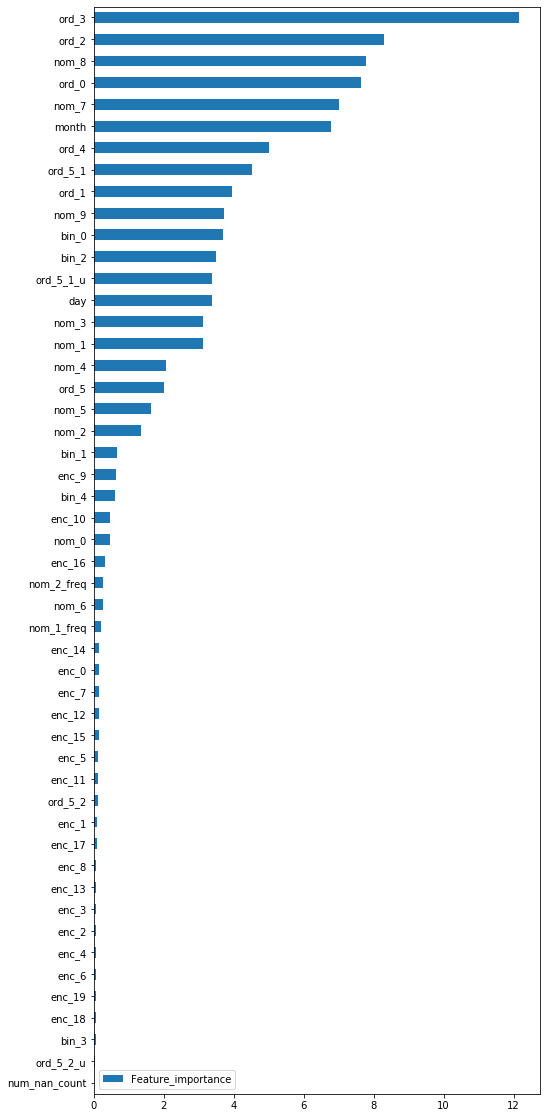

In [24]:
feature_importance = clf.get_feature_importance(
    Pool(X_valid, label=Y_valid, cat_features=all_cat_columns),
    type="FeatureImportance"
)
imp = pd.DataFrame(feature_importance, index=train.columns, columns=['Feature_importance'])
imp.sort_values('Feature_importance').plot(kind='barh', figsize=(8,20))

## Label test data

In [20]:
score_valid = clf.predict_proba(X_valid)[:, 1]
score_test = clf.predict_proba(test)[:, 1]

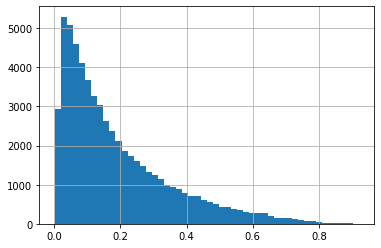

In [23]:
pd.Series(score_valid).hist(bins=50)

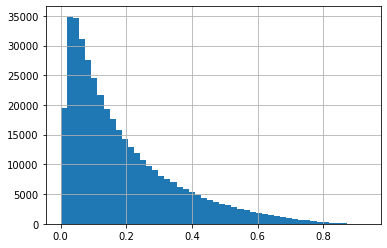

In [24]:
pd.Series(score_test).hist(bins=50)

In [25]:
from sklearn.metrics import confusion_matrix
thresholds = np.arange(0, 1, 0.01)[1:]
faux_neg = []
faux_pos = []
for threshold in thresholds:
    pred_valid = (score_valid > threshold)*1
    pred_test = (score_test > threshold)*1
    c = confusion_matrix(Y_valid, pred_valid)
    print(f'threshold {threshold}')
    print(c)
    print(f'faux neg valid: {c[1,0]/sum(c[:,0])}')
    faux_neg.append(c[1,0]/sum(c[:,0]))
    print(f'faux pos valid: {c[0,1]/sum(c[:,1])}')
    faux_pos.append(c[0,1]/sum(c[:,1]))
    print(f'nb 0 test: {len(pred_test) - sum(pred_test)}')
    print(f'nb 1 test: {sum(pred_test)}')
    print('-'*20)

threshold 0.01
[[  740 48073]
 [    2 11185]]
faux neg valid: 0.0026954177897574125
faux pos valid: 0.8112491140436734
nb 0 test: 5052
nb 1 test: 394948
--------------------
threshold 0.02
[[ 2953 45860]
 [   20 11167]]
faux neg valid: 0.006727211570803902
faux pos valid: 0.8041804759149175
nb 0 test: 20161
nb 1 test: 379839
--------------------
threshold 0.03
[[ 5759 43054]
 [   61 11126]]
faux neg valid: 0.010481099656357388
faux pos valid: 0.7946474713916575
nb 0 test: 38809
nb 1 test: 361191
--------------------
threshold 0.04
[[ 8627 40186]
 [  138 11049]]
faux neg valid: 0.015744438106103823
faux pos valid: 0.784346638040402
nb 0 test: 57983
nb 1 test: 342017
--------------------
threshold 0.05
[[11308 37505]
 [  238 10949]]
faux neg valid: 0.020613199376407414
faux pos valid: 0.7740331035621414
nb 0 test: 76808
nb 1 test: 323192
--------------------
threshold 0.06
[[13794 35019]
 [  363 10824]]
faux neg valid: 0.02564102564102564
faux pos valid: 0.7638897977881028
nb 0 test: 946

nb 1 test: 28478
--------------------
threshold 0.49
[[47136  1677]
 [ 8788  2399]]
faux neg valid: 0.15714183534797224
faux pos valid: 0.411432777232581
nb 0 test: 373350
nb 1 test: 26650
--------------------
threshold 0.5
[[47280  1533]
 [ 8918  2269]]
faux neg valid: 0.15868892131392576
faux pos valid: 0.40320883745397157
nb 0 test: 375133
nb 1 test: 24867
--------------------
threshold 0.51
[[47384  1429]
 [ 9036  2151]]
faux neg valid: 0.16015597305919888
faux pos valid: 0.39916201117318434
nb 0 test: 376827
nb 1 test: 23173
--------------------
threshold 0.52
[[47508  1305]
 [ 9138  2049]]
faux neg valid: 0.16131765702785722
faux pos valid: 0.389087656529517
nb 0 test: 378490
nb 1 test: 21510
--------------------
threshold 0.53
[[47626  1187]
 [ 9259  1928]]
faux neg valid: 0.16276698602443526
faux pos valid: 0.3810593900481541
nb 0 test: 380095
nb 1 test: 19905
--------------------
threshold 0.54
[[47745  1068]
 [ 9390  1797]]
faux neg valid: 0.16434759779469676
faux pos valid: 

/brain/engine/.cache/poetry/engine-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/brain/engine/.cache/poetry/engine-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


nb 1 test: 0
--------------------
threshold 0.9400000000000001
[[48813     0]
 [11187     0]]
faux neg valid: 0.18645
faux pos valid: nan
nb 0 test: 400000
nb 1 test: 0
--------------------
threshold 0.9500000000000001
[[48813     0]
 [11187     0]]
faux neg valid: 0.18645
faux pos valid: nan
nb 0 test: 400000
nb 1 test: 0
--------------------
threshold 0.96
[[48813     0]
 [11187     0]]
faux neg valid: 0.18645
faux pos valid: nan
nb 0 test: 400000
nb 1 test: 0
--------------------
threshold 0.97
[[48813     0]
 [11187     0]]
faux neg valid: 0.18645
faux pos valid: nan
nb 0 test: 400000
nb 1 test: 0
--------------------
threshold 0.98
[[48813     0]
 [11187     0]]
faux neg valid: 0.18645
faux pos valid: nan
nb 0 test: 400000
nb 1 test: 0
--------------------
threshold 0.99
[[48813     0]
 [11187     0]]
faux neg valid: 0.18645
faux pos valid: nan
nb 0 test: 400000
nb 1 test: 0
--------------------


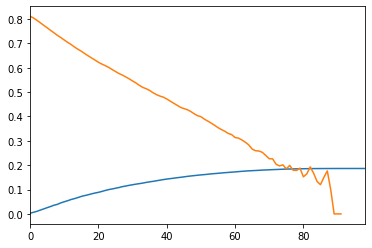

In [26]:
pd.Series(faux_neg).plot()
pd.Series(faux_pos).plot()

In [27]:
optimal_thres = 0.05
filter_test = (score_test < optimal_thres)

In [35]:
train = pd.read_csv('cat_in_dat/train.csv')
test = pd.read_csv('cat_in_dat/test.csv')
train.drop(['target'], axis=1, inplace=True)

In [36]:
test_filter = test.loc[filter_test, :]
y_test = np.array([0 for i in range(test_filter.shape[0])])

In [37]:
big_train = pd.concat([train, test_filter])
big_y = np.hstack([y_train, y_test])
big_train['target'] = big_y

In [38]:
big_train.to_csv('cat_in_dat/train_and_some_test.csv', index=False)

## Stacking

In [35]:
df_submission_1 = pd.read_csv('cat_in_dat/catboost_cross_val_le_fe.csv')
df_submission_2 = pd.read_csv('cat_in_dat/submission_embeddings.csv')
score = np.array([df_submission_1.target, df_submission_2.target])

df_submission = pd.DataFrame(np.array([df_submission_1.id, score.mean(axis=0)]).T, columns=['id', 'target'])
df_submission['id'] = df_submission['id'].astype('int')
df_submission.to_csv('cat_in_dat/stacking_catboost_embeddings.csv', index=False)